In [15]:
## This script performs simulations that inform the timing requirements for the proposed Digital Noise Source...
## This started from a script sent around by Kevin Bandura (henceforth KB)

## Begin with import statements from Kevin:
import numpy as np
from matplotlib.pyplot import *
from scipy.special import erf
import math
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [16]:
def quantizer(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    # Now assumes a complex number as well.  
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    scaling1 = desired_rms/(a.real).std()
    quantized_a_real = np.round((a.real)*scaling1,0)
    high_mask = (quantized_a_real > max_high)
    quantized_a_real[high_mask] = max_high
    low_mask = (quantized_a_real < max_low)
    quantized_a_real[low_mask] = max_low
    quantized_a_imag = np.round((a.imag)*scaling1,0)
    high_mask = (quantized_a_imag > max_high)
    quantized_a_imag[high_mask] = max_high
    low_mask = (quantized_a_imag < max_low)
    quantized_a_imag[low_mask] = max_low
    quantized_a = quantized_a_real + 1.0j*quantized_a_imag
    return quantized_a

def quantizer_WT(a, scaling=None, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    if scaling==None:
        scaling1 = desired_rms/a.std()
    elif type(scaling)==np.float64:
        scaling1=scaling
    quantized_a_real = np.round((a.real)*scaling1,0)
    high_mask = (quantized_a_real > max_high)
    quantized_a_real[high_mask] = max_high
    low_mask = (quantized_a_real < max_low)
    quantized_a_real[low_mask] = max_low
    quantized_a_imag = np.round((a.imag)*scaling1,0)
    high_mask = (quantized_a_imag > max_high)
    quantized_a_imag[high_mask] = max_high
    low_mask = (quantized_a_imag < max_low)
    quantized_a_imag[low_mask] = max_low
    quantized_a = quantized_a_real + 1.0j*quantized_a_imag
    return quantized_a

def quantizer_WT_scaling(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    scaling1 = desired_rms/a.std()
    return scaling1

## Functions for Index Shift and Phase Shift from total timing difference:
# Each time index is 2.56us, we want total time/2.56us to give us the number of indices, ignoring remainder.
# Each phase shift depends on frequency... each 2pi occurs on timescale 1/f, want remainder to find phase shift

def Index_Shift_From_Time(time_array):
    return (time_array/(2.56e-6)).astype(int)
    
def Phase_Shift_From_Time(time_array,frequency):
    return time_array/(frequency**-1.0)%(2*np.pi)

## Sources of time delay:
## 1) Freespace drone to telescope (depends on position, max when drone+telescope same altitude, time is dist/c)
## 2) Frontend telescope cables (time is length/0.85c)
## 3) Jitter from clock variations?

## What should our total lag time be? (This is the quasi-fixed lag between a drone signal and a correlator signal)
## How big should we expect our free-space lags to be?
SOL=299792458.0  #m/s
typdist=np.sqrt((100.0**2.0)+(175.0**2.0))
FS_Lag=typdist/SOL
print("A reasonable estimate for the FS_Lag is {:.4f}us".format(1e6*FS_Lag))
print(" --> During tests at GBO the drone was typically less than {:.2f} m away".format(typdist))
print(" --> This corresponds to a free-space lag of {:.4f}us".format(1e6*typdist/SOL))
## How big should we expect our front-end lags to be?
FE_Lag=100.0/(0.85*SOL)
print("A reasonable estimate for the FE_Lag is {:.4f}s".format(1e6*FE_Lag))
print(" --> If there are 100m of cable the front-end lag should be {:.4f}us".format(1e6*100.0/(0.85*SOL)))
## And thus the total is...?
print("A reasonable estimate for the Total_Lag=FS_Lag+FE_Lag is {:.4f}us".format(1e6*(FS_Lag+FE_Lag)))
## How far would the drone need to be to account for an index shift if we include front-end lag?
print("The drone would need to be {:.2f} m away to account for a 1 index shift".format(SOL*(2.56e-6-FE_Lag)))

t_length=16384
## What about jitter? Kevin seems to think that over hours 10s of ns is a reasonable jitter to expect...
clk_jitter_100ns=np.abs(np.random.normal(0,10e-9,t_length))
clk_jitter_100ps=np.abs(np.random.normal(0,100e-12,t_length))
print("Average simulated jitter on 1 hour timescales is {:.4f}ns".format(np.nanmean(clk_jitter_100ns)*1e9))
print("Average simulated jitter on 2.56us timescales is {:.4f}ps".format(np.nanmean(clk_jitter_100ps)*1e12))

## DEFN the Gauss Fit function:
def Gauss(x,a,x0,sigma,k):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k

A reasonable estimate for the FS_Lag is 0.6723us
 --> During tests at GBO the drone was typically less than 201.56 m away
 --> This corresponds to a free-space lag of 0.6723us
A reasonable estimate for the FE_Lag is 0.3924s
 --> If there are 100m of cable the front-end lag should be 0.3924us
A reasonable estimate for the Total_Lag=FS_Lag+FE_Lag is 1.0647us
The drone would need to be 649.82 m away to account for a 1 index shift
Average simulated jitter on 1 hour timescales is 8.0071ns
Average simulated jitter on 2.56us timescales is 80.0408ps


In [17]:
## 1) Looping through jitter space with fixed typical lag ~1us to study SNR:
    # I'm moving this up because its simply more relevant now, and the other code has redundant variable assmt.

## Select fixed params that dictate run properties:
looplen=1000
fman=526e6 #select freq
t_length=16384
#jitter_space=1e-12*np.ones(looplen)
jitter_space=np.linspace(1e-12,15e-9,looplen)
gains=[1.4,4.5,27.30]
gainlen=len(gains)
inputpower=2**5.5

## Define parameter arrays that we want to pull out for each jitter we test:
max_ind_auto=np.zeros((gainlen,looplen)).astype(int)
max_ind_cross=np.zeros((gainlen,looplen)).astype(int)
corr_scaling=np.zeros((gainlen,looplen))
max_mag_auto_on=np.zeros((gainlen,looplen))
max_mag_auto_off=np.zeros((gainlen,looplen))
max_mag_cross_on=np.zeros((gainlen,looplen))
max_mag_cross_off=np.zeros((gainlen,looplen))
med_mag_cross_off=np.zeros((gainlen,looplen))
mean_mag_cross_off=np.zeros((gainlen,looplen))
std_mag_cross_off=np.zeros((gainlen,looplen))
max_phi_auto=np.zeros((gainlen,looplen))
max_phi_cross=np.zeros((gainlen,looplen))
max_SNR_auto=np.zeros((gainlen,looplen))
max_SNR_cross_raw=np.zeros((gainlen,looplen))
max_SNR_cross_med=np.zeros((gainlen,looplen))
max_SNR_cross_mean=np.zeros((gainlen,looplen))
max_SNR_cross_std=np.zeros((gainlen,looplen))

## Create our signal arrays before quantization and phase factor:
signal=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))
noise_term=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))
noise_term_off=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))

for g,gain in enumerate(gains):
    f_signal_on=(gain*signal)+noise_term
    f_signal_off=noise_term_off
    for i,jitter in enumerate(jitter_space):
        ## Draw a sample to populate the jitter array and construct index shift/phase:
        simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+np.random.normal(0,jitter,t_length)
        index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
        phase_rads=Phase_Shift_From_Time(simtimearr,fman)
        phase_array=np.exp(-1.0j*phase_rads)
        ## create the f and q arrays:
        f_signal_on_ps=np.roll(phase_array*f_signal_on,index_shift)
        f_signal_off_ps=np.roll(phase_array*f_signal_off,index_shift)
        #on_scaling=quantizer_WT_scaling(f_signal_on_ps,nbits=8)
        on_scaling=np.nanmin([0.25*127.0/np.nanmean(np.abs(np.real(f_signal_on_ps))),0.25*127.0/np.nanmean(np.abs(np.imag(f_signal_on_ps)))])
        corr_scaling[g,i]=on_scaling
        q_signal_on_ps=quantizer_WT(f_signal_on_ps,scaling=on_scaling,nbits=8)
        q_signal_off_ps=quantizer_WT(f_signal_off_ps,scaling=on_scaling,nbits=8)
        q_signal=quantizer_WT((gain*signal),scaling=on_scaling,nbits=8)
        ## Perform correlations (unquantized):
        #auto_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal_on_ps)))
        #auto_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal_off_ps)))
        #cross_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(signal)))
        #cross_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(signal)))
        ## Perform correlations (quantized):
        auto_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
        auto_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
        cross_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
        cross_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
        ## Populate loop auto variables from runs:
        max_ind_auto[g,i]=np.where(np.abs(auto_corr_on_ps)==np.nanmax(np.abs(auto_corr_on_ps)))[0][0]
        max_mag_auto_on[g,i]=np.abs(auto_corr_on_ps[max_ind_auto[g,i]])
        max_mag_auto_off[g,i]=np.abs(auto_corr_off_ps[max_ind_auto[g,i]])
        max_phi_auto[g,i]=np.angle((auto_corr_on_ps)[max_ind_auto[g,i]])
        ## Populate loop cross variables from runs:
        max_ind_cross[g,i]=np.where(np.abs(cross_corr_on_ps)==np.nanmax(np.abs(cross_corr_on_ps)))[0][0]
        max_mag_cross_on[g,i]=np.abs(cross_corr_on_ps[max_ind_cross[g,i]])
        max_mag_cross_off[g,i]=np.abs(cross_corr_off_ps[max_ind_cross[g,i]])
        max_phi_cross[g,i]=np.angle(cross_corr_on_ps[max_ind_cross[g,i]])
        median_cross_off=np.nanmean(np.abs(cross_corr_off_ps))
        mean_cross_off=np.nanmedian(np.abs(cross_corr_off_ps))
        std_cross_off=np.nanstd(cross_corr_off_ps)
        med_mag_cross_off[g,i]=median_cross_off
        mean_mag_cross_off[g,i]=mean_cross_off
        std_mag_cross_off[g,i]=std_cross_off
        max_SNR_auto[g,i]=(np.abs(max_mag_auto_on[g,i])-np.abs(max_mag_auto_off[g,i]))/np.abs(max_mag_auto_off[g,i])
        max_SNR_cross_raw[g,i]=(np.abs(max_mag_cross_on[g,i])-np.abs(max_mag_cross_off[g,i]))/np.abs(max_mag_cross_off[g,i])
        max_SNR_cross_med[g,i]=(np.abs(cross_corr_on_ps[max_ind_cross[g,i]])-median_cross_off)/median_cross_off
        max_SNR_cross_mean[g,i]=(np.abs(cross_corr_on_ps[max_ind_cross[g,i]])-mean_cross_off)/mean_cross_off
        max_SNR_cross_std[g,i]=(np.abs(cross_corr_on_ps[max_ind_cross[g,i]])-std_cross_off)/std_cross_off

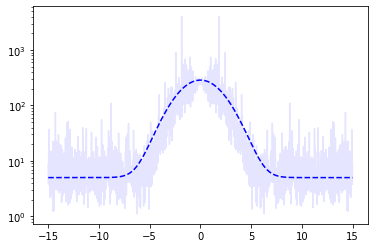

In [19]:
#Don't need any more:

## Try cheeky gauss fit? Gauss(x,a,x0,sigma,k)=a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k
ga=100.0
gx0=0.0
gsigma=2.50
gk=0.0
## have to mirror data to get a good symmetric about 0 result...
gtdat=np.concatenate((-1.0*jitter_space[::-1]*1e9,jitter_space*1e9))
gydat=np.concatenate((max_SNR_cross_raw[g,::-1],max_SNR_cross_raw[g,:]))
popt,pcov=curve_fit(Gauss,gtdat,gydat,p0=[ga,gx0,gsigma,gk])
semilogy(gtdat,gydat,'b',alpha=0.1)
semilogy(gtdat,Gauss(gtdat,*popt),'b--')
#Don't need any more:semilogy(jitter_space*1e9,Gauss(jitter_space*1e9,*popt),'k')

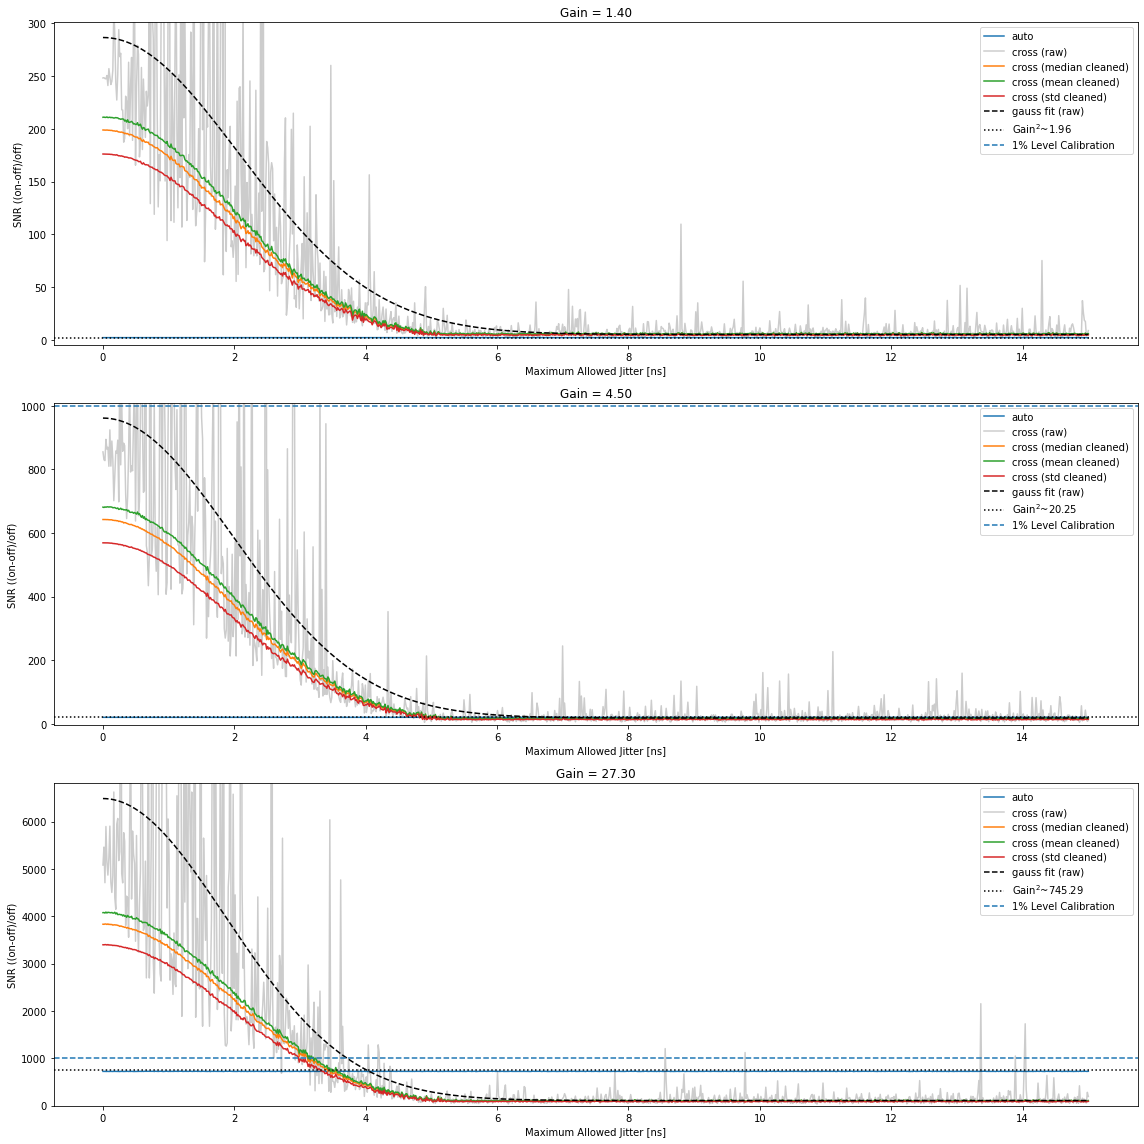

In [20]:
fig,[ax1,ax2,ax3]=subplots(nrows=3,ncols=1,figsize=(16,16))
for g,ax in enumerate([ax1,ax2,ax3]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,max_SNR_auto[g,:],label='auto')
    ax.plot(jitter_space*1e9,max_SNR_cross_raw[g,:],c='k',alpha=0.2,label='cross (raw)')
    ax.plot(jitter_space*1e9,max_SNR_cross_med[g,:],label='cross (median cleaned)')
    ax.plot(jitter_space*1e9,max_SNR_cross_mean[g,:],label='cross (mean cleaned)')
    ax.plot(jitter_space*1e9,max_SNR_cross_std[g,:],label='cross (std cleaned)')
    gtdat=np.concatenate((-1.0*jitter_space[::-1]*1e9,jitter_space*1e9))
    gydat=np.concatenate((max_SNR_cross_raw[g,::-1],max_SNR_cross_raw[g,:]))
    popt,pcov=curve_fit(Gauss,gtdat,gydat,p0=[ga,gx0,gsigma,gk])
    ax.plot(jitter_space*1e9,Gauss(jitter_space*1e9,*popt),'k--',label='gauss fit (raw)')
    ax.set_ylabel("SNR ((on-off)/off)")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.set_ylim(-5,1.05*np.nanmax([np.nanmax(max_SNR_cross_mean[g]),np.nanmax(max_SNR_cross_med[g]),np.nanmax(Gauss(jitter_space*1e9,*popt))]))
    ax.axhline(gains[g]**2.0,c='k',linestyle='dotted',label='Gain$^2$~{:.2f}'.format(gains[g]**2.0))
    ax.axhline(1000,linestyle='dashed',label='1% Level Calibration')
    ax.legend()
tight_layout()

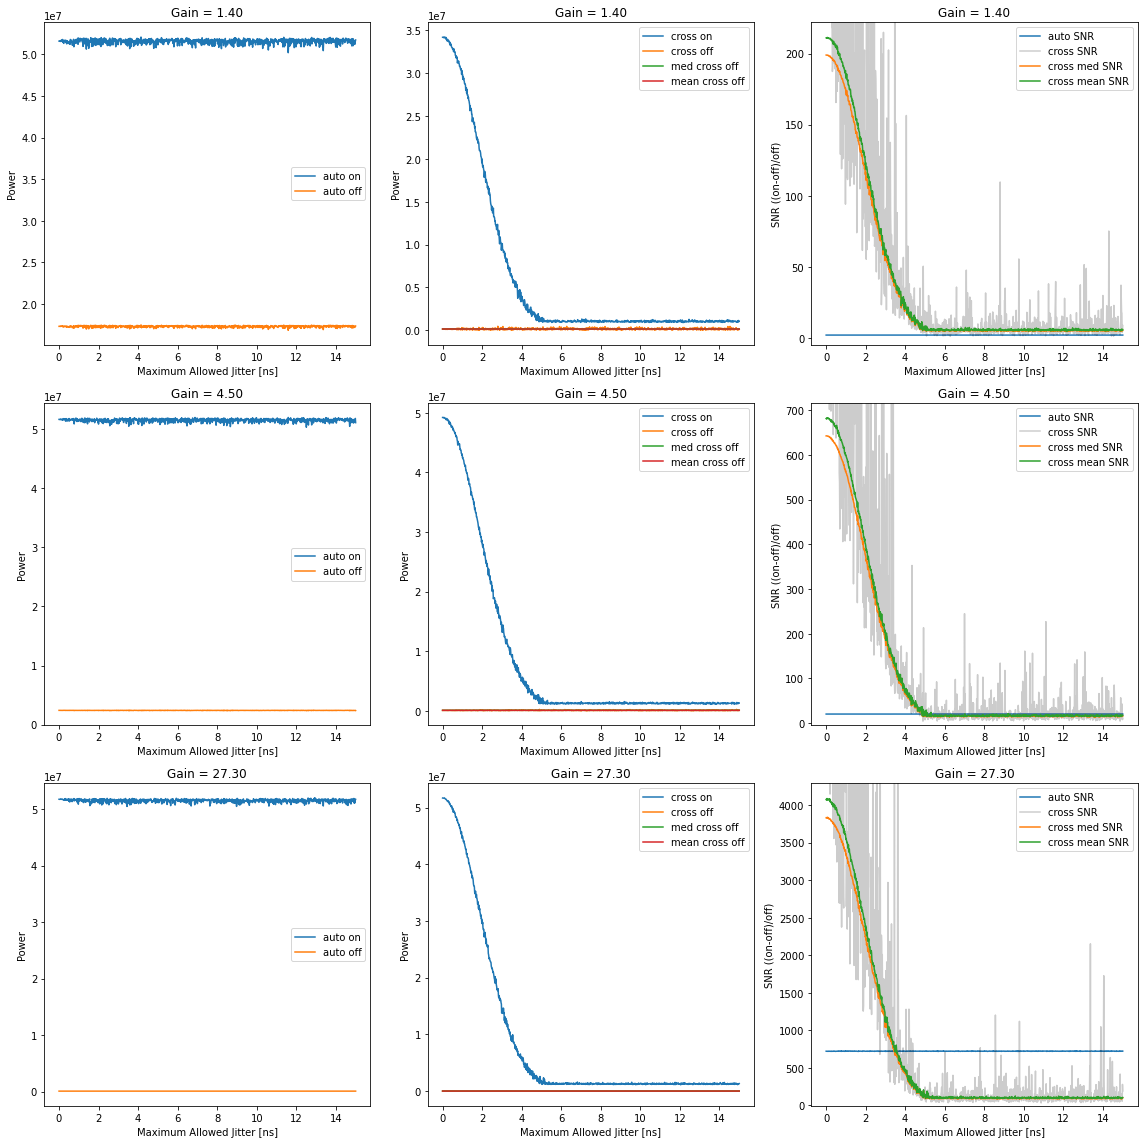

In [21]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=subplots(nrows=3,ncols=3,figsize=(16,16))
for g,ax in enumerate([ax1,ax4,ax7]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,max_mag_auto_on[g,:],label='auto on')
    ax.plot(jitter_space*1e9,max_mag_auto_off[g,:],label='auto off')
    ax.set_ylabel("Power")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
for g,ax in enumerate([ax2,ax5,ax8]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,max_mag_cross_on[g,:],label='cross on')
    ax.plot(jitter_space*1e9,max_mag_cross_off[g,:],label='cross off')
    ax.plot(jitter_space*1e9,med_mag_cross_off[g,:],label='med cross off')
    ax.plot(jitter_space*1e9,mean_mag_cross_off[g,:],label='mean cross off')
    ax.set_ylabel("Power")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
for g,ax in enumerate([ax3,ax6,ax9]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,max_SNR_auto[g,:],label='auto SNR')
    ax.plot(jitter_space*1e9,max_SNR_cross_raw[g,:],c='k',alpha=0.2,label='cross SNR')
    ax.plot(jitter_space*1e9,max_SNR_cross_med[g,:],label='cross med SNR')
    ax.plot(jitter_space*1e9,max_SNR_cross_mean[g,:],label='cross mean SNR')
    try:
        ax.set_ylim(-5,1.05*np.nanmax([np.nanmax(max_SNR_cross_mean[g]),np.nanmax(max_SNR_cross_med[g])]))
    except ValueError:
        pass
    ax.set_ylabel("SNR ((on-off)/off)")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
tight_layout()

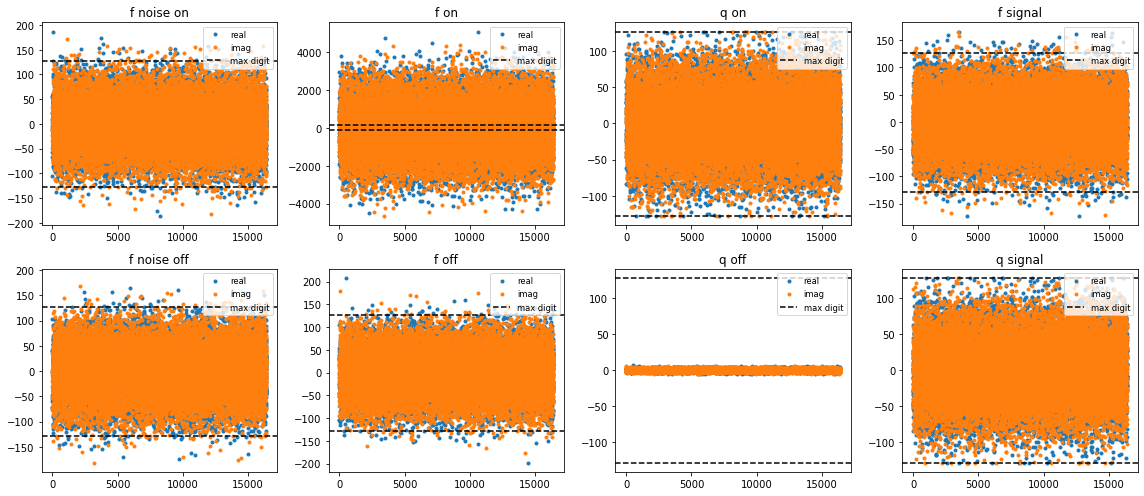

In [22]:
fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,7))
ax1.plot(np.real(noise_term),'.',label='real')
ax5.plot(np.real(noise_term_off),'.',label='real')
ax2.plot(np.real(f_signal_on_ps),'.',label='real')
ax6.plot(np.real(f_signal_off_ps),'.',label='real')
ax3.plot(np.real(q_signal_on_ps),'.',label='real')
ax7.plot(np.real(q_signal_off_ps),'.',label='real')
ax4.plot(np.real(signal),'.',label='real')
ax8.plot(np.real(q_signal),'.',label='real')
ax1.plot(np.imag(noise_term),'.',label='imag')
ax5.plot(np.imag(noise_term_off),'.',label='imag')
ax2.plot(np.imag(f_signal_on_ps),'.',label='imag')
ax6.plot(np.imag(f_signal_off_ps),'.',label='imag')
ax3.plot(np.imag(q_signal_on_ps),'.',label='imag')
ax7.plot(np.imag(q_signal_off_ps),'.',label='imag')
ax4.plot(np.imag(signal),'.',label='imag')
ax8.plot(np.imag(q_signal),'.',label='imag')
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    ax.axhline(+127,c='k',linestyle='dashed',label='max digit')
    ax.axhline(-128,c='k',linestyle='dashed')
    #ax.set_ylim(-200,300)
#for i,ax in enumerate([ax4,ax8]):
    #ax.axhline(127*t_length*(gains[g]+1))
titlist=["f noise on","f on","q on","f signal","f noise off","f off","q off","q signal"]
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    ax.set_title("{}".format(titlist[i]))
    ax.legend(loc=1,fontsize='small')
tight_layout()

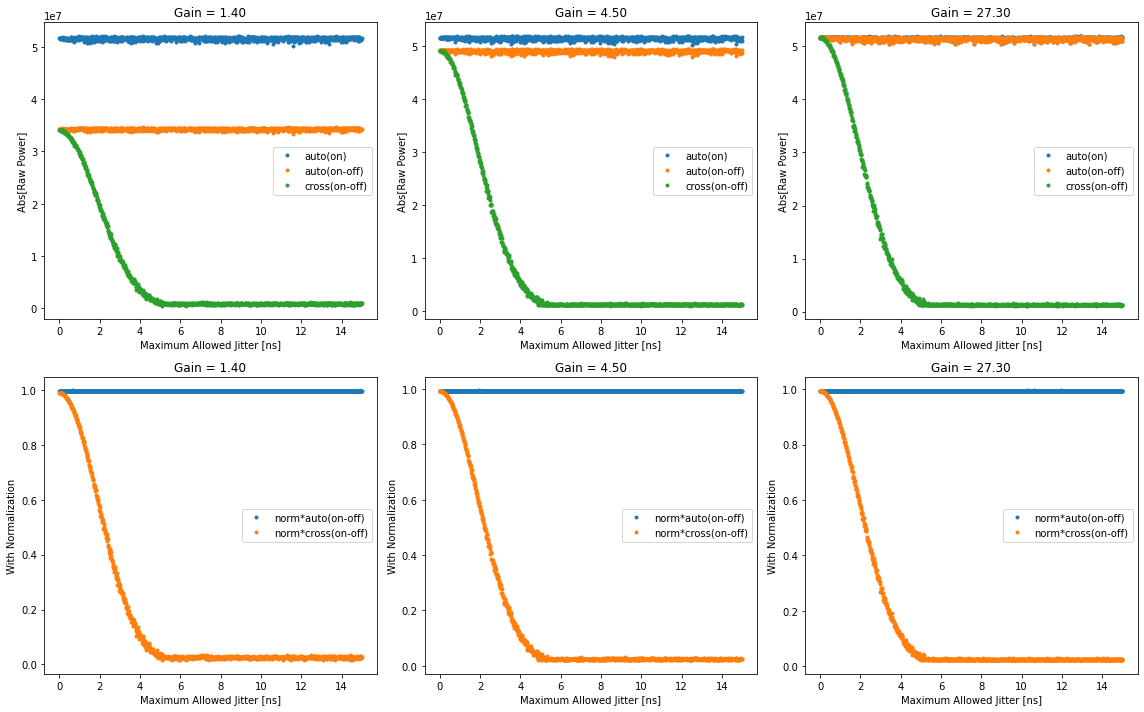

In [23]:
## Testing Normalizations for the Recovered Gains Metric:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(16,10))
for g,ax in enumerate([ax1,ax2,ax3]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    norm=1.0
    ax.plot(jitter_space*1e9,norm*np.abs(max_mag_auto_on[g,:]),'.',label='auto(on)')
    ax.plot(jitter_space*1e9,norm*(np.abs(max_mag_auto_on[g,:])-np.abs(max_mag_auto_off[g,:])),'.',label='auto(on-off)')
    ax.plot(jitter_space*1e9,norm*(np.abs(max_mag_cross_on[g,:])-np.abs(max_mag_cross_off[g,:])),'.',label='cross(on-off)')
    ax.set_ylabel("Abs[Raw Power]")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
for g,ax in enumerate([ax4,ax5,ax6]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ## IF mult signal by gain:
    norm=1.0/(2*(inputpower**2.0)*(corr_scaling[g,:]**2.0)*(t_length)*(gains[g]**2.0))
    ## IF div noise by gain:
    #norm=1.0/(2*(inputpower**2.0)*(corr_scaling[g,:]**2.0)*(t_length))
    ax.plot(jitter_space*1e9,norm*(np.abs(max_mag_auto_on[g,:])-np.abs(max_mag_auto_off[g,:])),'.',label='norm*auto(on-off)')
    ax.plot(jitter_space*1e9,norm*(np.abs(max_mag_cross_on[g,:])-np.abs(max_mag_cross_off[g,:])),'.',label='norm*cross(on-off)')
    #ax.plot(jitter_space*1e9,(np.abs(max_mag_cross_on[g,:])-np.abs(max_mag_cross_off[g,:]))/(127*16384*(gains[g]**2.0)),'.',label='cross/gain$^2$')
    #ax.plot(jitter_space*1e9,(np.abs(max_mag_auto_on[g,:])-np.abs(max_mag_auto_off[g,:]))/(127*16384*(gains[g]**2.0)),'.',label='auto/gain$^2$')
    ax.set_ylabel("With Normalization")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
tight_layout()

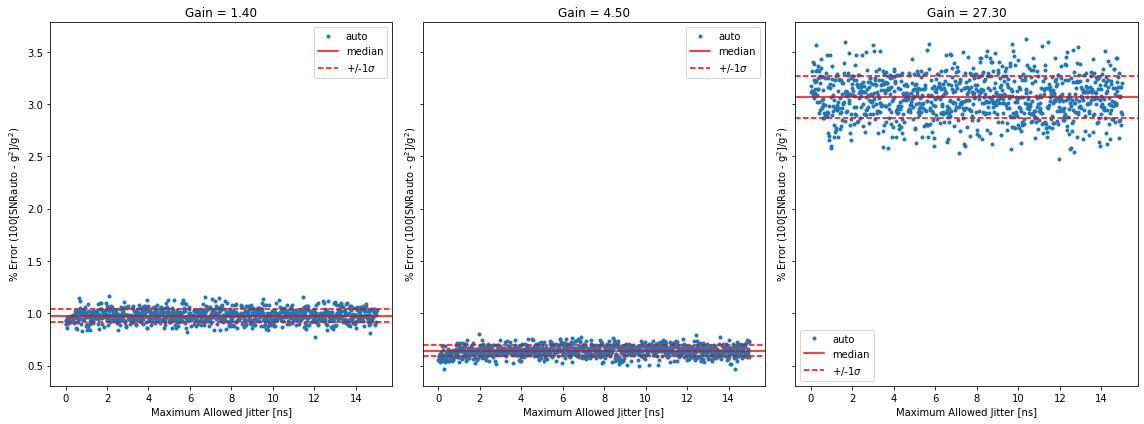

In [24]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6),sharey=True)
for g,ax in enumerate([ax1,ax2,ax3]):
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0,'.',label='auto')
    ax.axhline(np.nanmedian(100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0),c='r',label='median')
    ax.axhline(np.nanmedian(100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0)+np.nanstd(100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0),c='r',linestyle='dashed',label='+/-1$\sigma$')
    ax.axhline(np.nanmedian(100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0)-np.nanstd(100*np.abs(max_SNR_auto[g,:]-gains[g]**2.0)/gains[g]**2.0),c='r',linestyle='dashed')
    ax.set_ylabel("% Error (100[SNRauto - g$^2$]/g$^2$)")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    ax.legend()
tight_layout()

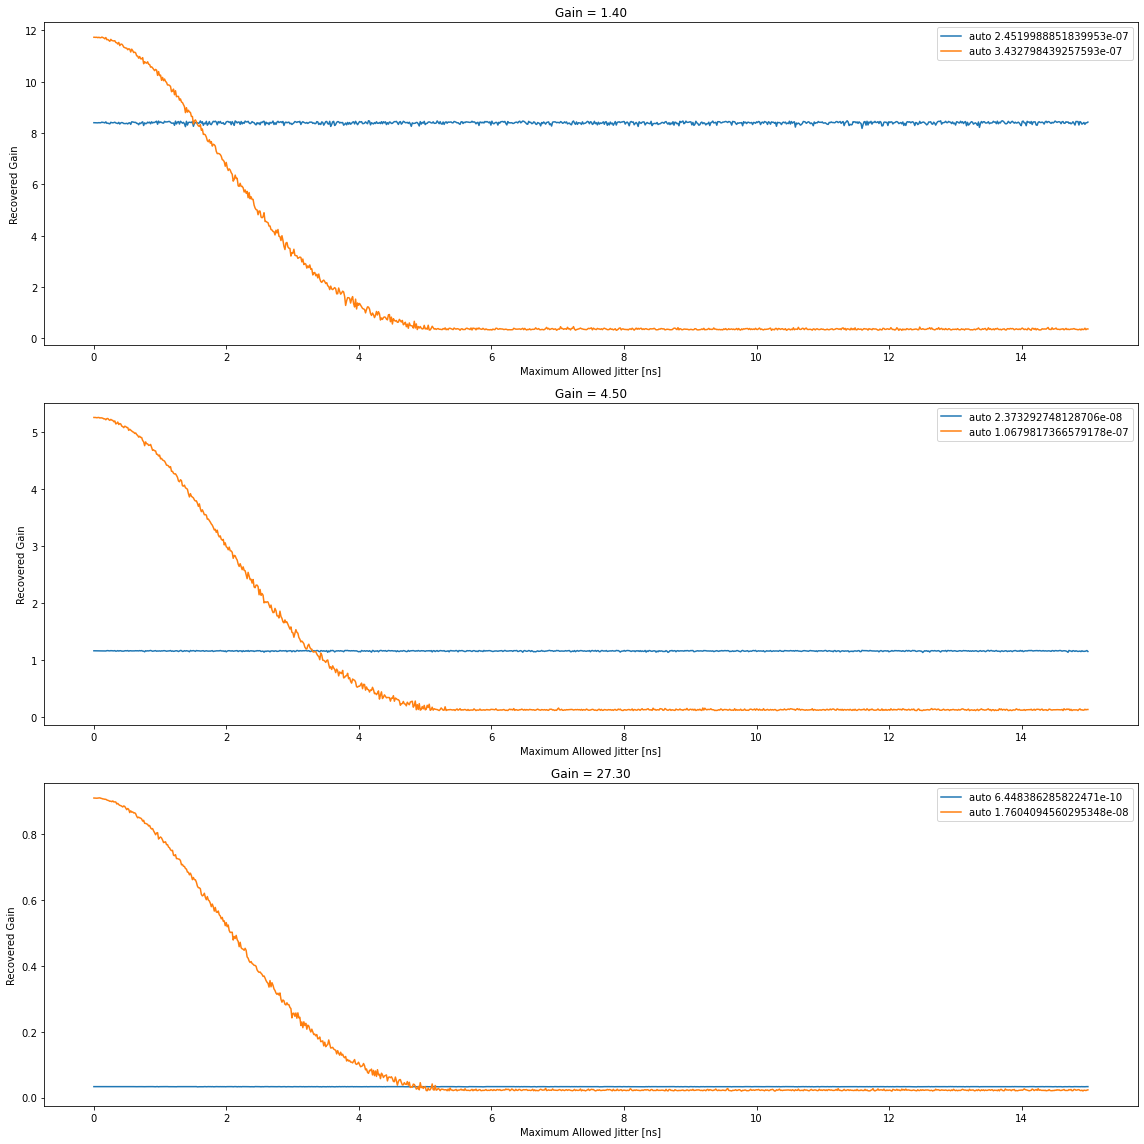

In [25]:
# Using Kalyani's recovered gain method:
fig,[ax1,ax2,ax3]=subplots(nrows=3,ncols=1,figsize=(16,16))
for g,ax in enumerate([ax1,ax2,ax3]):
    autonorm=1.0/((127*t_length*gains[g]**2.0))
    crossnorm=1.0/(127*t_length*gains[g])
    ax.set_title("Gain = {:.2f}".format(gains[g]))
    ax.plot(jitter_space*1e9,(max_mag_auto_on[g,:]-max_mag_auto_off[g,:])*autonorm,label='auto {}'.format(autonorm))
    ax.plot(jitter_space*1e9,max_mag_cross_on[g,:]*crossnorm,label='auto {}'.format(crossnorm))
#     ax.plot(jitter_space*1e9,max_SNR_cross_raw[g,:],c='k',alpha=0.2,label='cross (raw)')
#     ax.plot(jitter_space*1e9,max_SNR_cross_med[g,:],label='cross (median cleaned)')
#     ax.plot(jitter_space*1e9,max_SNR_cross_mean[g,:],label='cross (mean cleaned)')
#     ax.plot(jitter_space*1e9,max_SNR_cross_std[g,:],label='cross (std cleaned)')
    ax.set_ylabel("Recovered Gain")
    ax.set_xlabel('Maximum Allowed Jitter [ns]')
    #ax.set_ylim(-5,1.05*np.nanmax([np.nanmax(max_SNR_cross_mean[g]),np.nanmax(max_SNR_cross_med[g])]))
    #ax.axhline(gains[g]**2.0,c='k',linestyle='dotted',label='Gain$^2$~{:.2f}'.format(gains[g]**2.0))
    #ax.axhline(1000,linestyle='dashed',label='1% Level Calibration')
    ax.legend()
tight_layout()

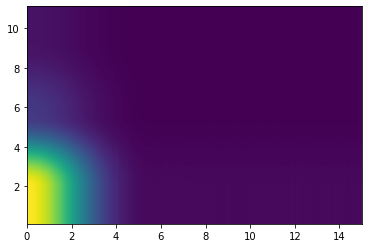

In [26]:
imshow((max_SNR_cross_std-1000),aspect='auto',extent=[0,15,0.11,11.11])

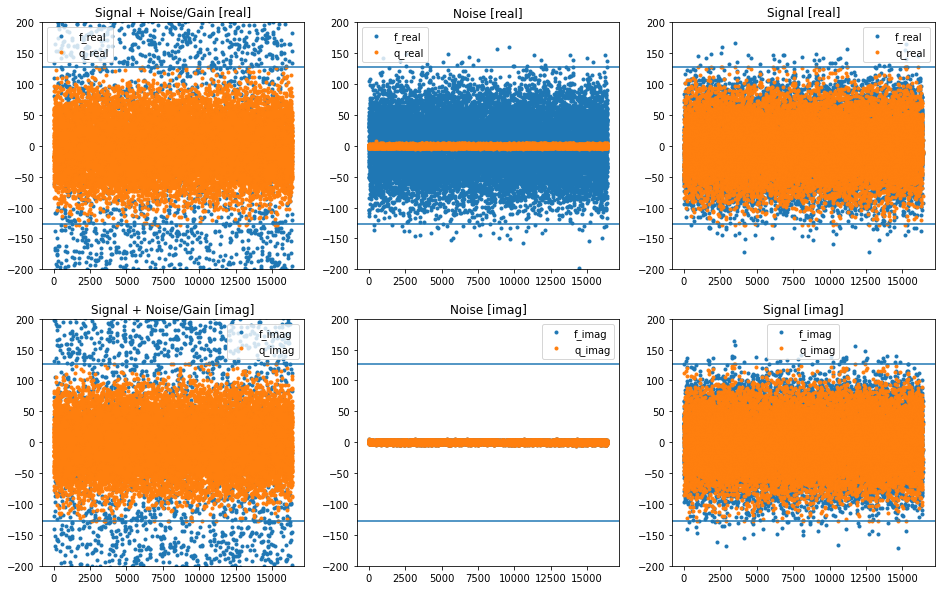

In [27]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(16,10))
ax1.set_title("Signal + Noise/Gain [real]")
ax1.plot(np.real(f_signal_on_ps),'.',label="f_real")
ax1.plot(np.real(q_signal_on_ps),'.',label="q_real")
ax4.set_title("Signal + Noise/Gain [imag]")
ax4.plot(np.imag(f_signal_on_ps),'.',label="f_imag")
ax4.plot(np.imag(q_signal_on_ps),'.',label="q_imag")
ax2.set_title("Noise [real]")
ax2.plot(np.real(f_signal_off_ps),'.',label="f_real")
ax2.plot(np.real(q_signal_off_ps),'.',label="q_real")
ax5.set_title("Noise [imag]")
ax5.plot(np.imag(q_signal_off_ps),'.',label="f_imag")
ax5.plot(np.imag(q_signal_off_ps),'.',label="q_imag")
ax3.set_title("Signal [real]")
ax3.plot(np.real(signal),'.',label="f_real")
ax3.plot(np.real(q_signal),'.',label="q_real")
ax6.set_title("Signal [imag]")
ax6.plot(np.imag(signal),'.',label="f_imag")
ax6.plot(np.imag(q_signal),'.',label="q_imag")
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_ylim(-200,200)
    ax.axhline(127)
    ax.axhline(-127)
    ax.legend()

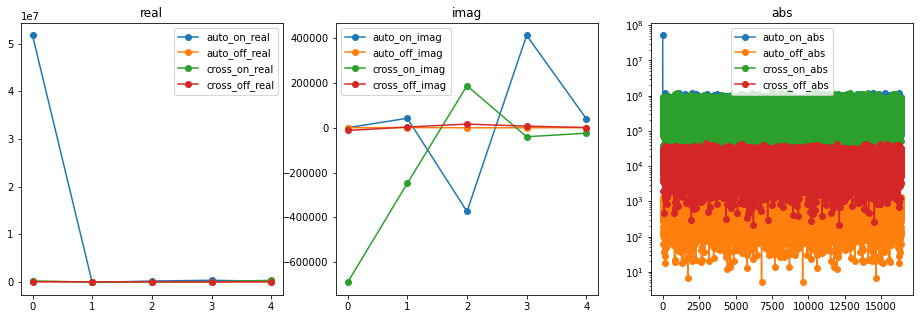

In [28]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
ax1.set_title("real")
ax1.plot(np.real(auto_corr_on_ps[:5]),'o-',label="auto_on_real")
ax1.plot(np.real(auto_corr_off_ps[:5]),'o-',label="auto_off_real")
ax1.plot(np.real(cross_corr_on_ps[:5]),'o-',label="cross_on_real")
ax1.plot(np.real(cross_corr_off_ps[:5]),'o-',label="cross_off_real")
ax2.set_title("imag")
ax2.plot(np.imag(auto_corr_on_ps[:5]),'o-',label="auto_on_imag")
ax2.plot(np.imag(auto_corr_off_ps[:5]),'o-',label="auto_off_imag")
ax2.plot(np.imag(cross_corr_on_ps[:5]),'o-',label="cross_on_imag")
ax2.plot(np.imag(cross_corr_off_ps[:5]),'o-',label="cross_off_imag")
ax3.set_title("abs")
ax3.plot(np.abs(auto_corr_on_ps),'o-',label="auto_on_abs")
ax3.plot(np.abs(auto_corr_off_ps),'o-',label="auto_off_abs")
ax3.plot(np.abs(cross_corr_on_ps),'o-',label="cross_on_abs")
ax3.semilogy(np.abs(cross_corr_off_ps),'o-',label="cross_off_abs")
for ax in [ax1,ax2,ax3]:
    ax.legend()

In [30]:
## 2) Looping through 1000 of same jitter to test noise properties for Kalyani's new metric:

## Select fixed params that dictate run properties:
fman=532e6 #select freq
t_length=16384
t_length=99
inputpower=2**5.5
iteration_space=np.arange(99)
jitter_space=np.linspace(1e-12,15e-9,99)
#gains=[1.111,5.55,11.11]
#gainlen=len(gains)
gain_space=np.linspace(0.25,127,99)

## Define parameter arrays that we want to pull out for each jitter we test:
q_corr_scaling=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
## Unquantized (f) correlations:
nq_max_ind_auto=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_ind_cross=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_mag_auto_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
nq_max_mag_auto_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
nq_max_mag_cross_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
nq_max_mag_cross_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
## Quantized (f) correlations:
q_max_ind_auto=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
q_max_ind_cross=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
q_max_mag_auto_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
q_max_mag_auto_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
q_max_mag_cross_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
q_max_mag_cross_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))

for i,iteration in enumerate(iteration_space):
    ## Create our signal arrays before quantization and phase factor:
    signal=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))
    noise_term=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))
    noise_term_off=(np.random.normal(0,inputpower,t_length)+1.0j*np.random.normal(0,inputpower,t_length))
    for g,gain in enumerate(gain_space):
        f_signal_on=(gain*signal)+noise_term
        f_signal_off=noise_term_off
        for j,jitter in enumerate(jitter_space):
            print('Iteration:{}/{}, Gain:{}/{}, Jitter:{}/{}    '.format(i+1,len(iteration_space),g+1,len(gain_space),j+1,len(jitter_space)),end='\r')
            ## Draw a sample to populate the jitter array and construct index shift/phase:
            simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+np.random.normal(0,jitter,t_length)
            index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
            phase_rads=Phase_Shift_From_Time(simtimearr,fman)
            phase_array=np.exp(-1.0j*phase_rads)
            ## create the f and q arrays:
            f_signal_on_ps=np.roll(phase_array*f_signal_on,index_shift)
            f_signal_off_ps=np.roll(phase_array*f_signal_off,index_shift)
            #on_scaling=quantizer_WT_scaling(f_signal_on_ps,nbits=8)
            on_scaling=np.nanmin([0.25*127.0/np.nanmean(np.abs(np.real(f_signal_on_ps))),0.25*127.0/np.nanmean(np.abs(np.imag(f_signal_on_ps)))])
            q_corr_scaling[j,g,i]=on_scaling
            q_signal_on_ps=quantizer_WT(f_signal_on_ps,scaling=on_scaling,nbits=8)
            q_signal_off_ps=quantizer_WT(f_signal_off_ps,scaling=on_scaling,nbits=8)
            q_signal=quantizer_WT((gain*signal),scaling=on_scaling,nbits=8)
            ## Perform correlations (unquantized):
            nq_auto_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal_on_ps)))
            nq_auto_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal_off_ps)))
            nq_cross_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(gain*signal)))
            nq_cross_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(gain*signal)))
            ## Perform correlations (quantized):
            q_auto_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
            q_auto_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
            q_cross_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
            q_cross_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
            ## Populate loop auto variables (unquantized):
            nq_max_ind_auto[j,g,i]=np.where(np.abs(nq_auto_corr_on_ps)==np.nanmax(np.abs(nq_auto_corr_on_ps)))[0][0]
            nq_max_mag_auto_on[j,g,i]=np.abs(nq_auto_corr_on_ps[nq_max_ind_auto[j,g,i]])
            nq_max_mag_auto_off[j,g,i]=np.abs(nq_auto_corr_off_ps[nq_max_ind_auto[j,g,i]])
            nq_max_ind_cross[j,g,i]=np.where(np.abs(nq_cross_corr_on_ps)==np.nanmax(np.abs(nq_cross_corr_on_ps)))[0][0]
            nq_max_mag_cross_on[j,g,i]=np.abs(nq_cross_corr_on_ps[nq_max_ind_cross[j,g,i]])
            nq_max_mag_cross_off[j,g,i]=np.abs(nq_cross_corr_off_ps[nq_max_ind_cross[j,g,i]])                  
            ## Populate loop cross variables (quantized):
            q_max_ind_auto[j,g,i]=np.where(np.abs(q_auto_corr_on_ps)==np.nanmax(np.abs(q_auto_corr_on_ps)))[0][0]
            q_max_mag_auto_on[j,g,i]=np.abs(q_auto_corr_on_ps[q_max_ind_auto[j,g,i]])
            q_max_mag_auto_off[j,g,i]=np.abs(q_auto_corr_off_ps[q_max_ind_auto[j,g,i]])
            q_max_ind_cross[j,g,i]=np.where(np.abs(q_cross_corr_on_ps)==np.nanmax(np.abs(q_cross_corr_on_ps)))[0][0]
            q_max_mag_cross_on[j,g,i]=np.abs(q_cross_corr_on_ps[q_max_ind_cross[j,g,i]])
            q_max_mag_cross_off[j,g,i]=np.abs(q_cross_corr_off_ps[q_max_ind_cross[j,g,i]])                  

Iteration: 99/99, Gain:99/99, Jitter: 99/99

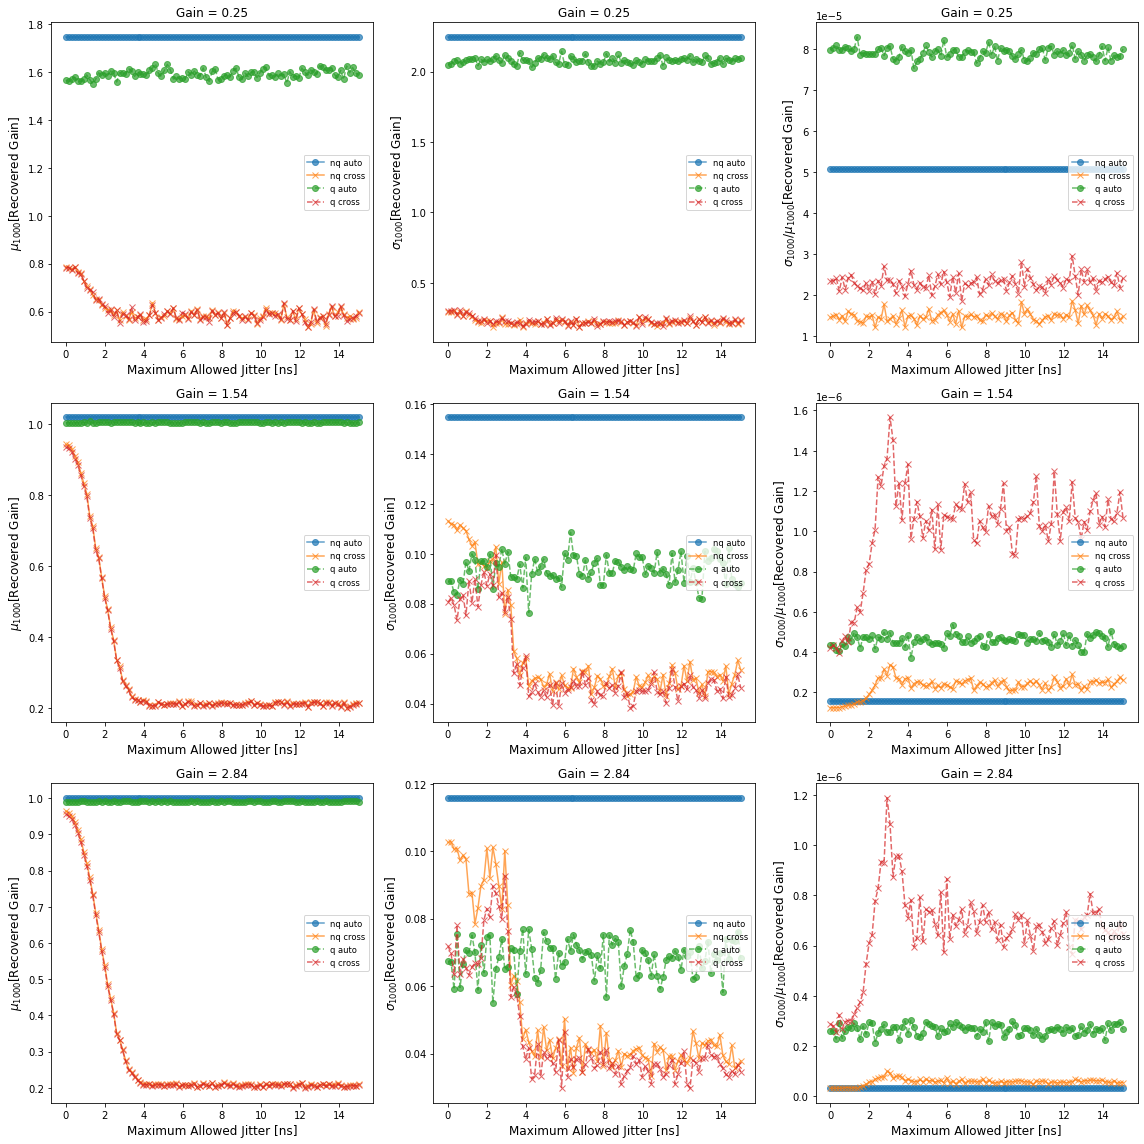

In [38]:
# Using Kalyani's recovered gain method:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=subplots(nrows=3,ncols=3,figsize=(16,16))
for g,ax in enumerate([ax1,ax4,ax7]):
    ## IF mult signal by gain:
    nq_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
    q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
    ## IF div noise by gain:
    #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
    #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
    ax.set_title("Gain = {:.2f}".format(gain_space[g]),fontsize='large')
    nq_x=nq_norm*np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
    nq_y=nq_norm*np.nanmean((np.abs(nq_max_mag_cross_on[:,g,:])-np.abs(nq_max_mag_cross_off[:,g,:])),axis=1)
    q_x=q_norm*np.nanmean((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)
    q_y=q_norm*np.nanmean((np.abs(q_max_mag_cross_on[:,g,:])-np.abs(q_max_mag_cross_off[:,g,:])),axis=1)
    ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
    ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
    ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q auto')
    ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
    ax.set_ylabel("$\mu_{1000}$[Recovered Gain]",fontsize='large')
    ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
    ax.legend(loc=5,fontsize='small')
for g,ax in enumerate([ax2,ax5,ax8]):
    ## IF mult signal by gain:
    nq_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
    q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
    ## IF div noise by gain:
    #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
    #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
    ax.set_title("Gain = {:.2f}".format(gain_space[g]),fontsize='large')
    nq_x=nq_norm*np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
    nq_y=nq_norm*np.nanstd((np.abs(nq_max_mag_cross_on[:,g,:])-np.abs(nq_max_mag_cross_off[:,g,:])),axis=1)
    q_x=q_norm*np.nanstd((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)
    q_y=q_norm*np.nanstd((np.abs(q_max_mag_cross_on[:,g,:])-np.abs(q_max_mag_cross_off[:,g,:])),axis=1)
    ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
    ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
    ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q auto')
    ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
    ax.set_ylabel("$\sigma_{1000}$[Recovered Gain]",fontsize='large')
    ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
    ax.legend(loc=5,fontsize='small')
for g,ax in enumerate([ax3,ax6,ax9]):
    ## IF mult signal by gain:
    nq_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
    q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
    ## IF div noise by gain:
    #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
    #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
    ax.set_title("Gain = {:.2f}".format(gain_space[g]),fontsize='large')
    nq_x=nq_norm*np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
    nq_y=nq_norm*np.nanstd((np.abs(nq_max_mag_cross_on[:,g,:])-np.abs(nq_max_mag_cross_off[:,g,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_cross_on[:,g,:])-np.abs(nq_max_mag_cross_off[:,g,:])),axis=1)
    q_x=q_norm*np.nanstd((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)/np.nanmean((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)
    q_y=q_norm*np.nanstd((np.abs(q_max_mag_cross_on[:,g,:])-np.abs(q_max_mag_cross_off[:,g,:])),axis=1)/np.nanmean((np.abs(q_max_mag_cross_on[:,g,:])-np.abs(q_max_mag_cross_off[:,g,:])),axis=1)
    ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
    ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
    ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q auto')
    ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
    ax.set_ylabel("$\sigma_{1000}$/$\mu_{1000}$[Recovered Gain]",fontsize='large')
    ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
    ax.legend(loc=5,fontsize='small')
tight_layout()

In [32]:
tsdims=(len(jitter_space),len(iteration_space),t_length)
signal=((np.random.normal(0,inputpower,tsdims)+1.0j*np.random.normal(0,inputpower,tsdims)))


In [ ]:
stop
np.savez("./jitter_space_auto_cross_mag_params1.npz",\
         max_ind_auto=max_ind_auto,\
         max_ind_cross=max_ind_cross,\
         max_mag_auto_on=max_mag_auto_on,\
         max_mag_auto_off=max_mag_auto_off,\
         max_mag_cross_on=max_mag_cross_on,\
         max_mag_cross_off=max_mag_cross_off)
dat=np.load("./jitter_space_auto_cross_mag_params1.npz")
list(dat.keys())

In [4]:
#Don't need any more:

## Variable assignment from KB:

## INPUT ARRAYS:
## 1) signal: length 100000 complex array populated with random magnitudes
signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
## 2) noise_term: length 100000 complex array populated with random magnitudes
noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
## 3) noise_term_off: length 100000 complex array populated with random magnitudes
noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
## 4) gain: integer
gain = 15

## COMPLEX FLOAT ARRAYS:
## 5) f_signal_on: length 100000 complex array constructed from previous vars
f_signal_on = signal + noise_term/gain 
## 6) f_signal_off: length 100000 complex array constructed from previous vars
f_signal_off = noise_term_off/gain

## COMPLEX INT ARRAYS (FROM QUANTIZATION):
## 7) q_signal_on: length 100000 complex array from running quantizer on f_signal_on
q_signal_on = quantizer(f_signal_on, nbits=8)
## 8) q_signal_off: length 100000 complex array from running quantizer on f_signal_off
q_signal_off = quantizer(f_signal_off, nbits=8)

It appears that the f_signal arrays gaussian distributed, while q_signal are quantized to integer levels:
--> the first value of f_signal_on is a complex float tuple: (3.4074511416324724+27.00776167907307j)
--> the first value of q_signal_on is a complex int tuple:   (1+7j)


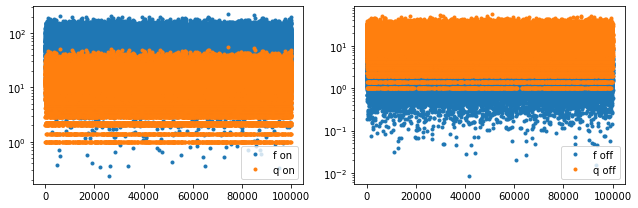

In [5]:
print("It appears that the f_signal arrays gaussian distributed, while q_signal are quantized to integer levels:")
print("--> the first value of f_signal_on is a complex float tuple: {}".format(f_signal_on[0]))
print("--> the first value of q_signal_on is a complex int tuple:   {}".format(q_signal_on[0]))

## Here I'm trying to plot the vars created by KB:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(9,3))
ax1.semilogy(np.abs(f_signal_on),'.',label='f on')
ax1.semilogy(np.abs(q_signal_on),'.',label='q on')
ax2.semilogy(np.abs(f_signal_off),'.',label='f off')
ax2.semilogy(np.abs(q_signal_off),'.',label='q off')
ax1.legend()
ax2.legend()
tight_layout()

In [6]:
## Performing auto-correlations on these quantized signal arrays: ifft(fft*fft)
auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:10000])*np.conjugate(np.fft.fft(q_signal_on[:10000])))
auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:10000])*np.conjugate(np.fft.fft(q_signal_off[:10000])))
## And cross-correlations between our noise added signal and raw signal
cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:10000])*np.conjugate(np.fft.fft(signal[:10000])))
cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:10000])*np.conjugate(np.fft.fft(signal[:10000])))
print("array lengths of input and auto correlation are: {} and {}".format(len(q_signal_on),len(auto_corr_on)))

array lengths of input and auto correlation are: 100000 and 10000


No handles with labels found to put in legend.


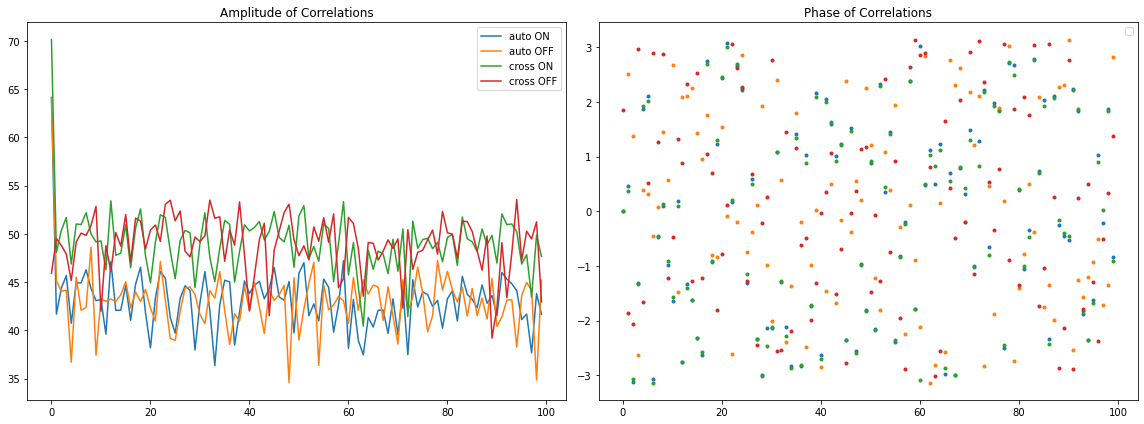

In [7]:
## EXPLANATION: The IFFT makes this graph behave like a lag correlator...
## i.e. each bin in the ifft is corresponds to a time, and the highest amp bin is all that matters
## in this example, the [0] bin has the highest amplitude since there is no shift in the signal and deltaT=0
## so we look at the complex phase of that bin [0] and we find that it is also zero
## When we add a phase factor or a deltaT index shift to one of the time arrays, we will find a peak for t>0.

fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,6))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...
ax1.set_title("Amplitude of Correlations")
ax1.plot(10*np.log10(np.abs(auto_corr_on[:100])), label="auto ON")
ax1.plot(10*np.log10(np.abs(auto_corr_off[:100])), label="auto OFF")
ax1.plot(10*np.log10(np.abs(cross_corr_on[:100])), label="cross ON")
ax1.plot(10*np.log10(np.abs(cross_corr_off[:100])), label="cross OFF")
ax1.legend()
## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
ax2.set_title("Phase of Correlations")
#ax2.plot(10*np.log10(np.abs(cross_corr_on)), label='ON')
#ax2.plot(10*np.log10(np.abs(cross_corr_off)), label="OFF")
ax2.plot(np.angle(auto_corr_on[:100]),'.')
ax2.plot(np.angle(auto_corr_off[:100]),'.')
ax2.plot(np.angle(cross_corr_on[:100]),'.')
ax2.plot(np.angle(cross_corr_off[:100]),'.')
ax2.legend()
tight_layout()

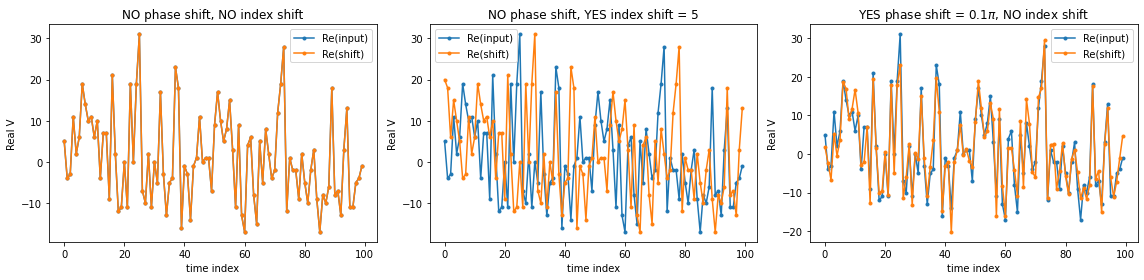

In [8]:
## Now let's do the cross correlation for a signal with a decided phase shift, and add real units later:

## Variable assignment for input random signal in this freq. bin:
t_length=16384

## INPUT ARRAYS:
## 1) signal: length 10000 complex array populated with random magnitudes
signal = (np.random.normal(0, 2**5.5, t_length) +1.0j*np.random.normal(0, 2**5.5, t_length))
## 2) noise_term: length 100000 complex array populated with random magnitudes
noise_term = (np.random.normal(0, 2**5.5, t_length) +1.0j*np.random.normal(0, 2**5.5, t_length))
## 3) noise_term_off: length 100000 complex array populated with random magnitudes
noise_term_off = (np.random.normal(0, 2**5.5, t_length) +1.0j*np.random.normal(0, 2**5.5, t_length))
## 4) gain: integer value
gain = 15

## COMPLEX V FLOAT ARRAYS:
## 5) f_signal_on: length 10000 complex array constructed from previous vars
f_signal_on = gain*signal + noise_term
## 6) f_signal_off: length 10000 complex array constructed from previous vars
f_signal_off = noise_term_off

## COMPLEX V INT ARRAYS (FROM QUANTIZATION):
## 7) q_signal: length 10000 complex array from running quantizer on signal
q_signal=quantizer(signal, nbits=8)
## 7) q_signal_on: length 10000 complex array from running quantizer on f_signal_on
q_signal_on = quantizer(f_signal_on, nbits=8)
## 8) q_signal_off: length 10000 complex array from running quantizer on f_signal_off
q_signal_off = quantizer(f_signal_off, nbits=8)

## PHASE PARAMETERS AND INDEX SHIFT ARRAYS:
index_shift=52
phase_factor=np.exp(1.0j*(0.9))
phase_array=phase_factor*np.ones(t_length)

## PHASE SHIFTED COMPLEX V INT ARRAYS:
q_signal_on_ps=np.roll(quantizer(phase_array*f_signal_on),index_shift)
q_signal_off_ps=np.roll(quantizer(phase_array*f_signal_off),index_shift)

fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,4))
ax1.set_title("NO phase shift, NO index shift")
ax1.plot(np.real(q_signal_on[:100]),'.-',label="Re(input)")
ax1.plot(np.real(np.roll(((np.exp(-1.0j*(0.0))*np.ones(t_length))*q_signal_on),0)[:100]),'.-',label="Re(shift)")
ax2.set_title("NO phase shift, YES index shift = 5")
ax2.plot(np.real(q_signal_on[:100]),'.-',label="Re(input)")
ax2.plot(np.real(np.roll(((np.exp(-1.0j*(0.0))*np.ones(t_length))*q_signal_on),5)[:100]),'.-',label="Re(shift)")
ax3.set_title("YES phase shift = 0.1$\pi$, NO index shift")
ax3.plot(np.real(q_signal_on[:100]),'.-',label="Re(input)")
ax3.plot(np.real(np.roll(((np.exp(-1.0j*(0.3))*np.ones(t_length))*q_signal_on),0)[:100]),'.-',label="Re(shift)")
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_ylabel("Real V")
    ax.set_xlabel("time index")
    ax.legend()
tight_layout()

In [9]:
## Now let's do the actual cross and auto correlation measurements and plot results:
## Performing auto-correlations on the unshifted V arrays: ifft(fft*fft)
auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on)*np.conjugate(np.fft.fft(q_signal_on)))
auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off)*np.conjugate(np.fft.fft(q_signal_off)))
## Performing auto-correlations on the shifted V arrays: ifft(fft*fft)
auto_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
auto_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
## And cross-correlations between our unshifted V and raw signal
cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on)*np.conjugate(np.fft.fft(q_signal)))
cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off)*np.conjugate(np.fft.fft(q_signal)))
## And cross-correlations between our shifted V and raw signal
cross_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
cross_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
## And cross-correlations between our unshifted V and shifted V
cross_corr_on_usps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on)))
cross_corr_off_usps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off)))

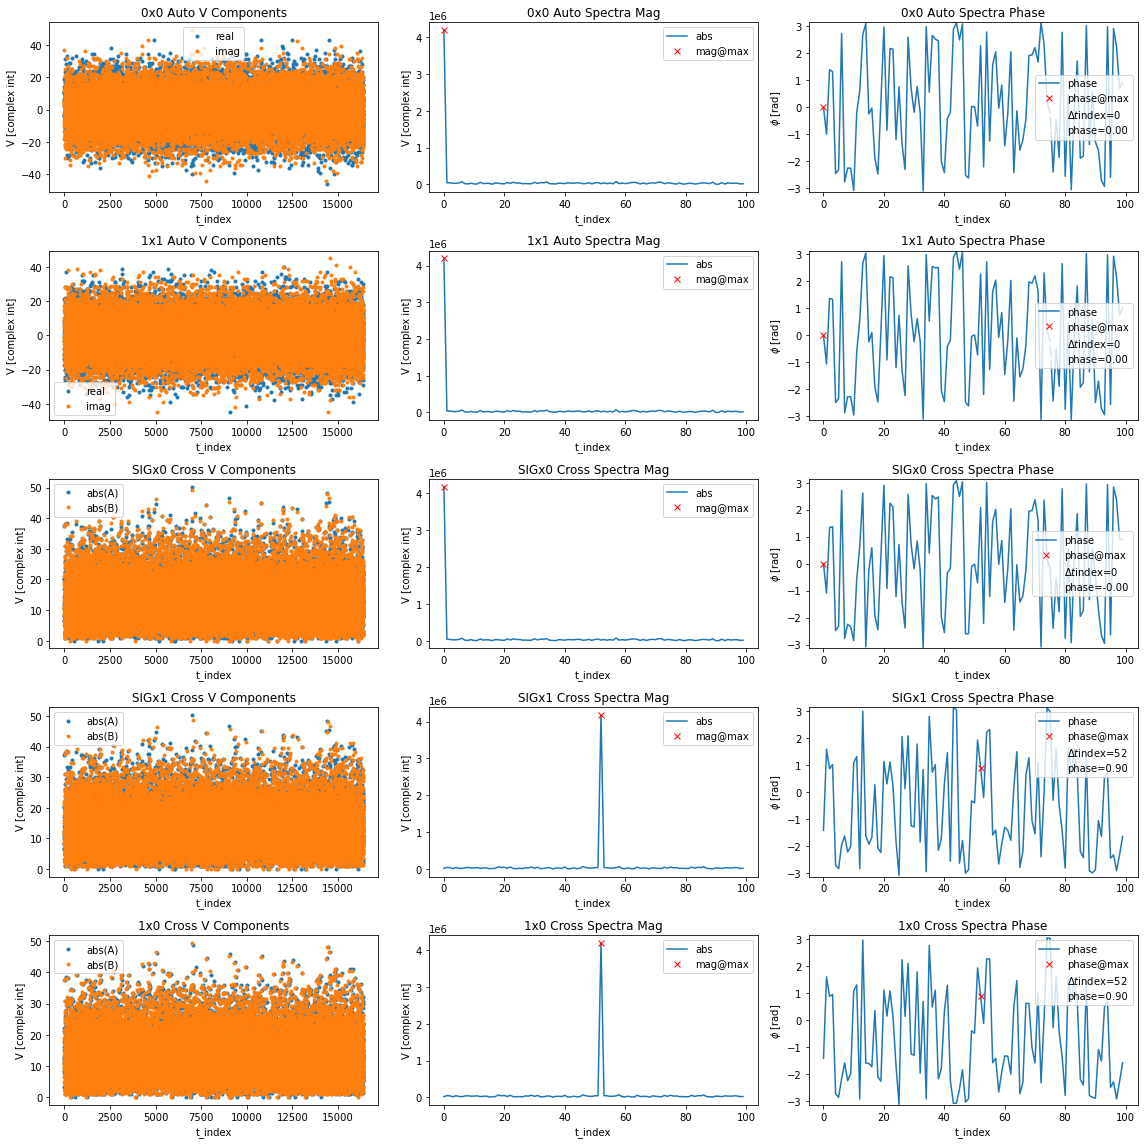

In [10]:
## And let's plot:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12],[ax13,ax14,ax15]]=subplots(nrows=5,ncols=3,figsize=(16,16))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...

titlekeys=["0x0 Auto","1x1 Auto","SIGx0 Cross","SIGx1 Cross","1x0 Cross"]

## For plotting loops, define variable lists annd iterate:
ch_list_auto=[q_signal_on,q_signal_on_ps] # what channels are being autoed?
for i,ax in enumerate([ax1,ax4]):
    ax.set_title("{} V Components".format(titlekeys[i]))
    ax.plot(np.real(ch_list_auto[i]),'.',label='real')
    ax.plot(np.imag(ch_list_auto[i]),'.',label='imag')
    #ax.plot(abs(ch_list_auto[i]),'.',label='abs')
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    ax.legend()

ch_list_cross=[[q_signal,q_signal_on],[q_signal,q_signal_on_ps],[q_signal_on_ps,q_signal_on]]
for i,ax in enumerate([ax7,ax10,ax13]):
    ax.set_title("{} V Components".format(titlekeys[i+2]))
    #ax.plot(np.real(ch_list_cross[i][0]),label='real(A)')
    #ax.plot(np.imag(ch_list_cross[i][0]),label='imag(A)')
    ax.plot(abs(ch_list_cross[i][0]),'.',label='abs(A)')
    #ax.plot(np.real(ch_list_cross[i][1]),'.',label='real(B)')
    #ax.plot(np.imag(ch_list_cross[i][1]),'.',label='imag(B)')
    ax.plot(abs(ch_list_cross[i][1]),'.',label='abs(B)')
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    ax.legend()

x_list=[auto_corr_on,auto_corr_on_ps,cross_corr_on,cross_corr_on_ps,cross_corr_on_usps]

for i,ax in enumerate([ax2,ax5,ax8,ax11,ax14]):
    ax.set_title("{} Spectra Mag".format(titlekeys[i]))
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    #ax.set_ylim(-1.1,1.1)
    #ax.plot(np.real(x_list[i][:100]), label="real")
    #ax.plot(np.imag(x_list[i][:100]), label="imag")
    ax.plot(np.abs(x_list[i][:100]), label="abs")
    maxind=np.where(np.abs(x_list[i])==np.max(np.abs([x_list[i]])))[0][0]
    ax.plot(maxind,np.abs(x_list[i][maxind]),'rx',label='mag@max')
    ax.legend()
## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
for i,ax in enumerate([ax3,ax6,ax9,ax12,ax15]):
    ax.set_title("{} Spectra Phase".format(titlekeys[i]))
    ax.plot(np.angle(x_list[i][:100]),label='phase')
    maxind=np.where(np.abs(x_list[i])==np.max(np.abs([x_list[i]])))[0][0]
    ax.plot(maxind,np.angle(x_list[i][maxind]),'rx',label='phase@max')
    ax.plot([],[],'w.',label='$\Delta t$index={}'.format(maxind))
    ax.plot([],[],'w.',label='phase={:.2f}'.format(np.angle(x_list[i][maxind])))
    ax.set_ylim(-np.pi,np.pi)
    ax.set_ylabel('$\phi$ [rad]')
    ax.set_xlabel('t_index')
    ax.legend()
tight_layout()

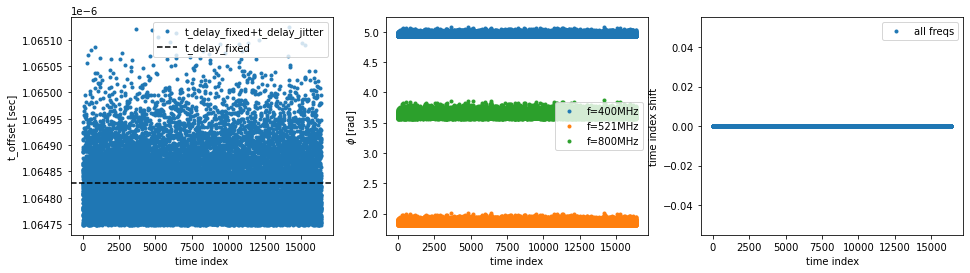

In [13]:
simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+clk_jitter_100ps

fig0,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,4))
ax1.plot(simtimearr,'.',label='t_delay_fixed+t_delay_jitter')
ax1.axhline(np.nanmean(simtimearr),c='k',linestyle='--',label='t_delay_fixed')
ax1.set_ylabel("t_offset [sec]")
ax2.plot(Phase_Shift_From_Time(simtimearr,400e6),'.',label="f=400MHz")
ax2.plot(Phase_Shift_From_Time(simtimearr,521e6),'.',label="f=521MHz")
ax2.plot(Phase_Shift_From_Time(simtimearr,800e6),'.',label="f=800MHz")
ax2.set_ylabel('$\phi$ [rad]')
ax3.plot(Index_Shift_From_Time(simtimearr),'.',label="all freqs")
ax3.set_ylabel("time index shift")

for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_xlabel("time index")
    ax.legend()

In [14]:
## Find the median index shift from the above time arrays:
index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
print("Applying an index shift of {}".format(index_shift))
## Create the phase array from the above time arrays:
fman=521e6 #select freq
phase_rads=Phase_Shift_From_Time(simtimearr,fman)
phase_array=np.exp(1.0j*phase_rads)
print("Applying element-wise phase (avg={:.2f}rad) for freq={}MHz".format(np.nanmean(phase_rads),fman*1e-6))
## PHASE SHIFTED COMPLEX V INT ARRAYS:
q_signal_on_ps=np.roll(quantizer(phase_array*f_signal_on),index_shift)
q_signal_off_ps=np.roll(quantizer(phase_array*f_signal_off),index_shift)

Applying an index shift of 0
Applying element-wise phase (avg=1.86rad) for freq=521.0MHz


In [15]:
## Now let's do the actual cross and auto correlation measurements and plot results:
## Performing auto-correlations on the unshifted V arrays: ifft(fft*fft)
auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on)*np.conjugate(np.fft.fft(q_signal_on)))
auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off)*np.conjugate(np.fft.fft(q_signal_off)))
## Performing auto-correlations on the shifted V arrays: ifft(fft*fft)
auto_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
auto_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
## And cross-correlations between our unshifted V and raw signal
cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on)*np.conjugate(np.fft.fft(q_signal)))
cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off)*np.conjugate(np.fft.fft(q_signal)))
## And cross-correlations between our shifted V and raw signal
cross_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
cross_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
## And cross-correlations between our unshifted V and shifted V
cross_corr_on_usps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on)))
cross_corr_off_usps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off)))

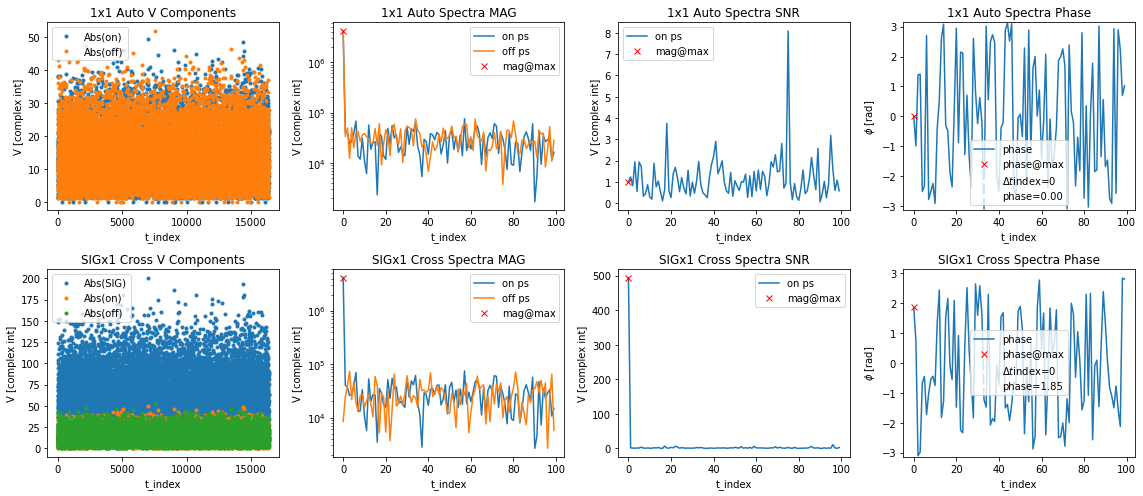

In [16]:
## And let's plot:
fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,7))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...

titlekeys=["1x1 Auto","SIGx1 Cross"]

labelkeys=[['Abs(on)','Abs(off)'],['Abs(SIG)','Abs(on)','Abs(off)']]
ch_list_cross=[[q_signal_on_ps,q_signal_off_ps],[signal,q_signal_on_ps,q_signal_off_ps]]
for i,ax in enumerate([ax1,ax5]):
    ax.set_title("{} V Components".format(titlekeys[i]))
    for j in range(len(ch_list_cross[i])):
        ax.plot(abs(ch_list_cross[i][j]),'.',label=labelkeys[i][j])
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    ax.legend()

x_list=[[auto_corr_on_ps,auto_corr_off_ps],[cross_corr_on_ps,cross_corr_off_ps]]
for i,ax in enumerate([ax2,ax6]):
    ax.set_title("{} Spectra MAG".format(titlekeys[i]))
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    ax.semilogy(np.abs(x_list[i][0][:100]), label="on ps")
    ax.semilogy(np.abs(x_list[i][1][:100]), label="off ps")
    maxind=np.where(np.abs(x_list[i][0])==np.max(np.abs([x_list[i][0]])))[0][0]
    ax.plot(maxind,np.abs(x_list[i][0][maxind]),'rx',label='mag@max')
    ax.legend()
for i,ax in enumerate([ax3,ax7]):
    ax.set_title("{} Spectra SNR".format(titlekeys[i]))
    ax.set_ylabel('V [complex int]')
    ax.set_xlabel('t_index')
    ax.plot(np.abs(x_list[i][0][:100])/np.abs(x_list[i][1][:100]), label="on ps")
    maxind=np.where(np.abs(x_list[i][0])==np.max(np.abs([x_list[i][0]])))[0][0]
    ax.plot(maxind,np.abs(x_list[i][0][maxind])/np.abs(x_list[i][1][maxind]),'rx',label='mag@max')
    ax.legend()
## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
for i,ax in enumerate([ax4,ax8]):
    ax.set_title("{} Spectra Phase".format(titlekeys[i]))
    ax.plot(np.angle(x_list[i][0][:100]),label='phase')
    maxind=np.where(np.abs(x_list[i][0])==np.max(np.abs([x_list[i][0]])))[0][0]
    ax.plot(maxind,np.angle(x_list[i][0][maxind]),'rx',label='phase@max')
    ax.plot([],[],'w.',label='$\Delta t$index={}'.format(maxind))
    ax.plot([],[],'w.',label='phase={:.2f}'.format(np.angle(x_list[i][0][maxind])))
    ax.set_ylim(-np.pi,np.pi)
    ax.set_ylabel('$\phi$ [rad]')
    ax.set_xlabel('t_index')
    ax.legend()
tight_layout()

In [17]:
## 1) Looping through lag space with 100ps jitter to study SNR: not very interesting, pretty flat...

looplen=1000
fman=521e6 #select freq

## Define parameter arrays that we want to pull out for each lag we test:
max_ind=np.zeros((looplen,2))
max_mag=np.zeros((looplen,2))
max_off_mag=np.zeros((looplen,2))
max_phi=np.zeros((looplen,2))
max_SNR=np.zeros((looplen,2))

lag_space=np.linspace(0.5e-6,4e-6,looplen)

for i,lag in enumerate(lag_space):
    simtimearr=(np.ones(t_length)*(lag))+clk_jitter_100ps
    index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
    phase_rads=Phase_Shift_From_Time(simtimearr,fman)
    phase_array=np.exp(1.0j*phase_rads)
    q_signal_on_ps=np.roll(quantizer(phase_array*f_signal_on),index_shift)
    q_signal_off_ps=np.roll(quantizer(phase_array*f_signal_off),index_shift)
    ## Performing auto-correlations on the shifted V arrays: ifft(fft*fft)
    auto_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
    auto_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
    ## And cross-correlations between our shifted V and raw signal
    cross_corr_on_ps = np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
    cross_corr_off_ps = np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
    corr_on_list=[auto_corr_on_ps,cross_corr_on_ps]
    corr_off_list=[auto_corr_off_ps,cross_corr_off_ps]
    for j,corr in enumerate(corr_on_list):
        maxind=np.where(np.abs(corr)==np.nanmax(np.abs(corr)))[0][0]
        max_ind[i,j]=maxind
        max_mag[i,j]=np.abs(corr[maxind])
        max_off_mag[i,j]=np.abs(corr_off_list[j])[maxind]
        max_phi[i,j]=np.angle(corr[maxind])
        max_SNR[i,j]=np.abs(corr[maxind])/np.abs(corr_off_list[j][maxind])

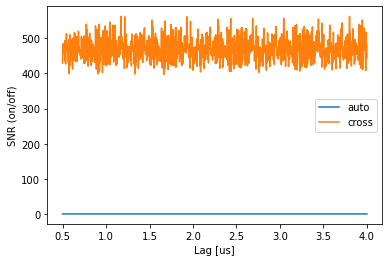

In [18]:
## axis1:(auto on, auto off, cross on, cross off)
plot(lag_space*1e6,max_SNR[:,0],label='auto')
plot(lag_space*1e6,max_SNR[:,1],label='cross')
ylabel("SNR (on/off)")
xlabel('Lag [us]')
legend()

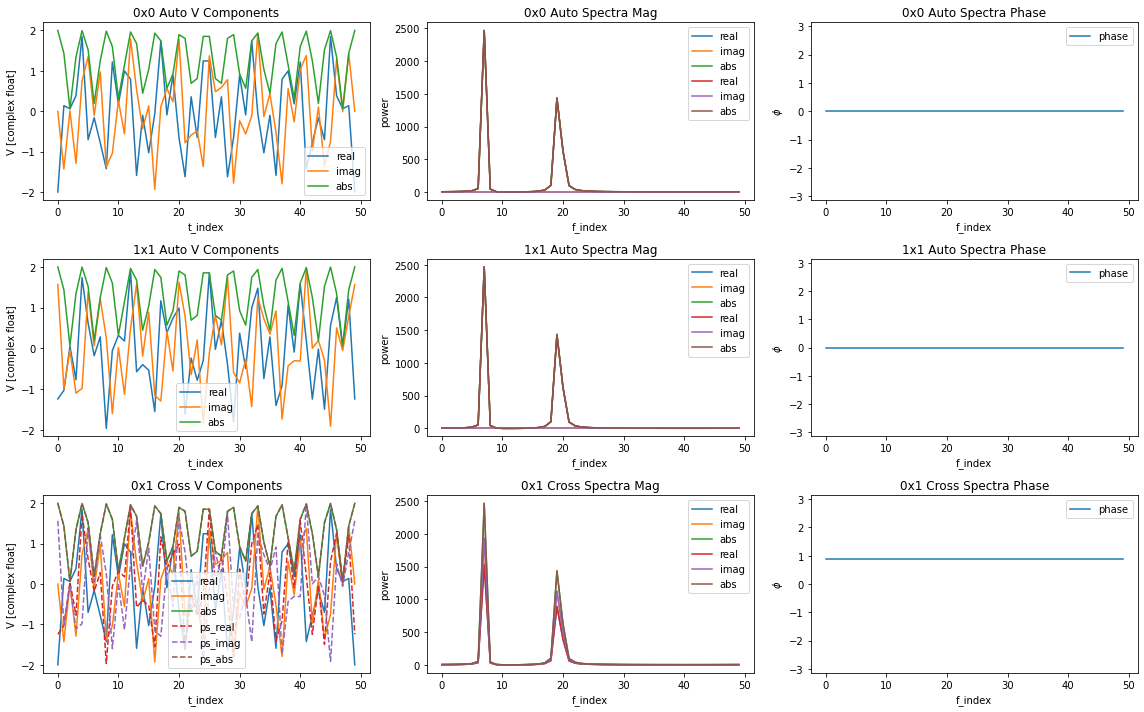

In [210]:
## It turns out this isn't needed. We should use the ifft because it will operate like a 1 freq lag correlator!

## Let's generate a complex array that is periodic just for kicks to test some correlation properties:
tt=7# number of periods scale factor
tt1=19
fbins=50
tester=np.cos(np.linspace(-tt*np.pi,tt*np.pi,fbins))+(1.0j*np.sin(np.linspace(-tt*np.pi,tt*np.pi,fbins)))+\
np.cos(np.linspace(-tt1*np.pi,tt1*np.pi,fbins))+(1.0j*np.sin(np.linspace(-tt1*np.pi,tt1*np.pi,fbins)))

## Introduce a constant phase factor to add a time delay to the signal, so we can find phase in cross: 
phase_factor=np.exp(-1.0j*(0.9))
tester_w_phase=phase_factor*tester

## What happens if we do the IFFT and FFT stuff to do the correlation in the frequency domain:
auto_tester = (np.fft.fft(tester)*np.conjugate(np.fft.fft(tester)))
auto_tester_w_phase = (np.fft.fft(tester_w_phase)*np.conjugate(np.fft.fft(tester_w_phase)))
cross_tester=(np.fft.fft(tester)*np.conjugate(np.fft.fft(tester_w_phase)))

## What if we did the correlations just in the time domain??
#auto_tester = ((tester)*np.conjugate((tester)))
#auto_tester_w_phase = ((tester_w_phase)*np.conjugate((tester_w_phase)))
#cross_tester=((tester)*np.conjugate(tester_w_phase))

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=subplots(nrows=3,ncols=3,figsize=(16,10))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...

f_list=[tester,tester_w_phase]
for i,ax in enumerate([ax1,ax4]):
    ax.set_title("{} V Components".format(titlekeys[i]))
    ax.plot(np.real(f_list[i]),label='real')
    ax.plot(np.imag(f_list[i]),label='imag')
    ax.plot(abs(f_list[i]),label='abs')
    ax.set_ylabel('V [complex float]')
    ax.set_xlabel('t_index')
    ax.legend()
for i,ax in enumerate([ax7]):
    ax.set_title("{} V Components".format(titlekeys[2]))
    ax.plot(np.real(f_list[0]),label='real')
    ax.plot(np.imag(f_list[0]),label='imag')
    ax.plot(abs(f_list[0]),label='abs')
    ax.plot(np.real(f_list[1]),'--',label='ps_real')
    ax.plot(np.imag(f_list[1]),'--',label='ps_imag')
    ax.plot(abs(f_list[1]),'--',label='ps_abs')
    ax.set_ylabel('V [complex float]')
    ax.set_xlabel('t_index')
    ax.legend()

x_list=[auto_tester,auto_tester_w_phase,cross_tester]

titlekeys=["0x0 Auto","1x1 Auto","0x1 Cross"]
for i,ax in enumerate([ax2,ax5,ax8]):
    ax.set_title("{} Spectra Mag".format(titlekeys[i]))
    ax.set_ylabel('power')
    ax.set_xlabel('f_index')
    #ax.set_ylim(-1.1,1.1)
    ax.plot(np.real(x_list[i]), label="real")
    ax.plot(np.imag(x_list[i]), label="imag")
    ax.plot(np.abs(x_list[i]), label="abs")
    ax.plot(np.real(x_list[i]), label="real")
    ax.plot(np.imag(x_list[i]), label="imag")
    ax.plot(np.abs(x_list[i]), label="abs")
    ax.legend()
## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
for i,ax in enumerate([ax3,ax6,ax9]):
    ax.set_title("{} Spectra Phase".format(titlekeys[i]))
    ax.plot(np.angle(x_list[i]),label='phase')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_ylabel('$\phi$')
    ax.set_xlabel('f_index')
    ax.legend()
tight_layout()

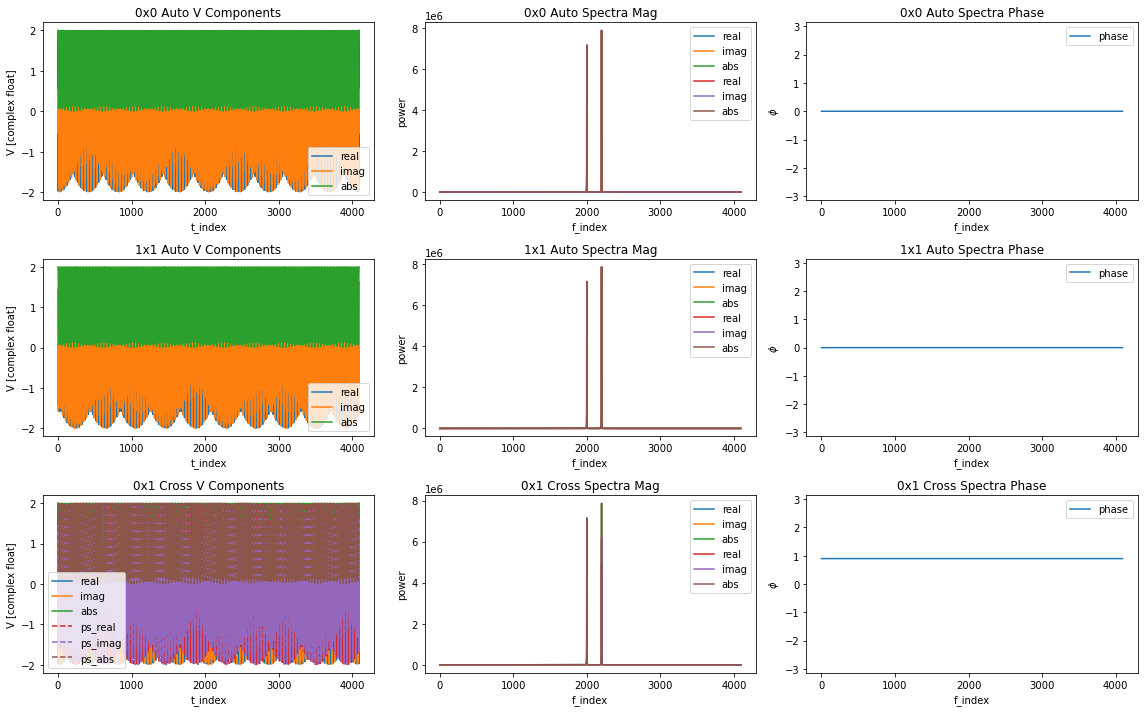

In [198]:
## It turns out this isn't needed. We should use the ifft because it will operate like a 1 freq lag correlator!

## Let's generate a complex array that is periodic just for kicks to test some correlation properties:
tt=2000 # number of periods scale factor
tt1=2200
fbins=4096
tester=np.cos(np.linspace(-tt*np.pi,tt*np.pi,fbins))+(1.0j*np.sin(np.linspace(-tt*np.pi,tt*np.pi,fbins)))+\
np.cos(np.linspace(-tt1*np.pi,tt1*np.pi,fbins))+(1.0j*np.sin(np.linspace(-tt1*np.pi,tt1*np.pi,fbins)))

## Introduce a constant phase factor to add a time delay to the signal, so we can find phase in cross: 
phase_factor=np.exp(-1.0j*(0.9))
tester_w_phase=phase_factor*tester

## What happens if we do the IFFT and FFT stuff to do the correlation in the frequency domain:
auto_tester = (np.fft.fft(tester)*np.conjugate(np.fft.fft(tester)))
auto_tester_w_phase = (np.fft.fft(tester_w_phase)*np.conjugate(np.fft.fft(tester_w_phase)))
cross_tester=(np.fft.fft(tester)*np.conjugate(np.fft.fft(tester_w_phase)))

## What if we did the correlations just in the time domain??
#auto_tester = ((tester)*np.conjugate((tester)))
#auto_tester_w_phase = ((tester_w_phase)*np.conjugate((tester_w_phase)))
#cross_tester=((tester)*np.conjugate(tester_w_phase))

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=subplots(nrows=3,ncols=3,figsize=(16,10))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...

f_list=[tester,tester_w_phase]
for i,ax in enumerate([ax1,ax4]):
    ax.set_title("{} V Components".format(titlekeys[i]))
    ax.plot(np.real(f_list[i]),label='real')
    ax.plot(np.imag(f_list[i]),label='imag')
    ax.plot(abs(f_list[i]),label='abs')
    ax.set_ylabel('V [complex float]')
    ax.set_xlabel('t_index')
    ax.legend()
for i,ax in enumerate([ax7]):
    ax.set_title("{} V Components".format(titlekeys[2]))
    ax.plot(np.real(f_list[0]),label='real')
    ax.plot(np.imag(f_list[0]),label='imag')
    ax.plot(abs(f_list[0]),label='abs')
    ax.plot(np.real(f_list[1]),'--',label='ps_real')
    ax.plot(np.imag(f_list[1]),'--',label='ps_imag')
    ax.plot(abs(f_list[1]),'--',label='ps_abs')
    ax.set_ylabel('V [complex float]')
    ax.set_xlabel('t_index')
    ax.legend()


x_list=[auto_tester,auto_tester_w_phase,cross_tester]

titlekeys=["0x0 Auto","1x1 Auto","0x1 Cross"]
for i,ax in enumerate([ax2,ax5,ax8]):
    ax.set_title("{} Spectra Mag".format(titlekeys[i]))
    ax.set_ylabel('power')
    ax.set_xlabel('f_index')
    #ax.set_ylim(-1.1,1.1)
    ax.plot(np.real(x_list[i]), label="real")
    ax.plot(np.imag(x_list[i]), label="imag")
    ax.plot(np.abs(x_list[i]), label="abs")
    ax.plot(np.real(x_list[i]), label="real")
    ax.plot(np.imag(x_list[i]), label="imag")
    ax.plot(np.abs(x_list[i]), label="abs")
    ax.legend()
## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
for i,ax in enumerate([ax3,ax6,ax9]):
    ax.set_title("{} Spectra Phase".format(titlekeys[i]))
    ax.plot(np.angle(x_list[i]),label='phase')
    ax.set_ylim(-np.pi,np.pi)
    ax.set_ylabel('$\phi$')
    ax.set_xlabel('f_index')
    ax.legend()
tight_layout()

In [886]:
100 + 5/5

101.0

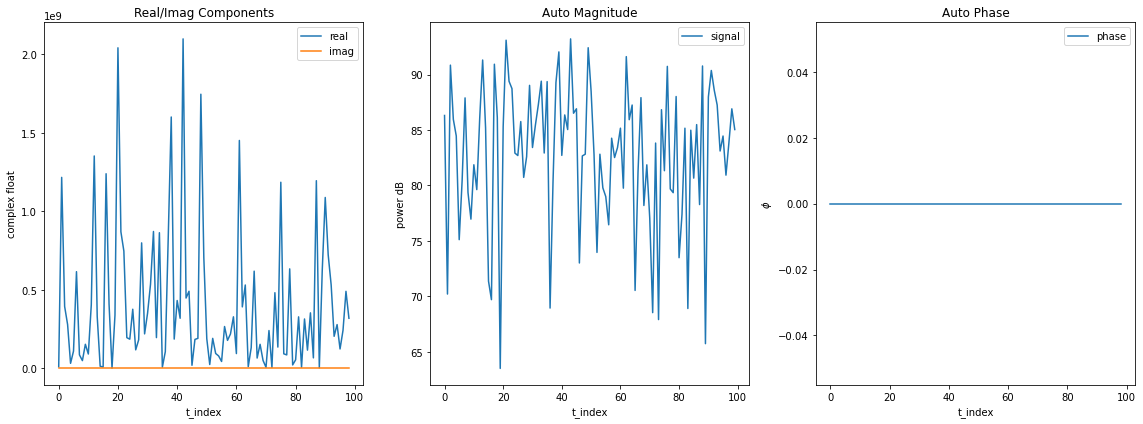

In [151]:
auto_signal = np.fft.ifft(np.fft.fft(signal[:100000])*np.conjugate(np.fft.fft(signal[:100000])))
#auto_signal = ((signal[:100000])*np.conjugate((phase_factor*signal[:100000])))

fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
## Lets plot the auto correlations: Note symmetry about midpoint t sample...
ax1.set_title("Real/Imag Components")
ax1.plot((np.real(auto_signal[1:100])), label="real")
ax1.plot((np.imag(auto_signal[1:100])), label="imag")
ax1.set_ylabel('complex float')
ax1.set_xlabel('t_index')
ax1.legend()

ax2.set_title("Auto Magnitude")
ax2.set_ylabel('power dB')
ax2.set_xlabel('t_index')
ax2.plot(10*np.log10(np.abs(auto_signal)[:100]), label="signal")
ax2.legend()

## Lets plot the cross correlations: Note there is NO symmetry about midpoint t sample... hmm...
ax3.set_title("Auto Phase")
ax3.plot(np.angle(auto_signal)[1:100],label='phase')
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('t_index')
ax3.legend()
tight_layout()

In [23]:
print(abs(auto_corr_on.mean())/abs(np.mean(auto_corr_off)))

154.2346973162022


In [24]:
print(abs(cross_corr_on.max())/abs(np.mean(cross_corr_off)))

5336195.201321807


In [25]:
print(abs(auto_corr_on.max())/abs(np.std(auto_corr_on)))

223.80653471840512


In [26]:
print(abs(cross_corr_on[0])/abs(cross_corr_off[0]))

4304.520745952699


In [27]:
print(abs(auto_corr_on[0])/abs(auto_corr_off[0]))

224.25461947599973


In [28]:
gains = np.arange(0.1,10,0.2)

In [29]:
snr_cross = []
snr_cross_no_quant = []
snr_auto = []
stop_time = 100000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    #signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    f_signal_on = signal + noise_term/gain  #this way to make quantization easier
    f_signal_off = noise_term_off/gain
    q_signal_on = quantizer(f_signal_on, nbits=8)
    q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(q_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(q_signal_off[:stop_time])))
    cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    snr_cross_no_quant1 = abs(cross_corr_on_no_quant[0])/abs(cross_corr_off_no_quant[0])
    snr_cross1 = abs(cross_corr_on[0])/abs(cross_corr_off[0])
    snr_auto1 = abs(auto_corr_on[0])/abs(auto_corr_off[0])
    snr_cross.append(snr_cross1)
    snr_auto.append(snr_auto1)
    snr_cross_no_quant.append(snr_cross_no_quant1)
    print("gain {}, snr auto= {}, snr_cross={}, snr_cross_no_quant={}".format(gain, snr_auto1, snr_cross1, snr_cross_no_quant1))

gain 0.1, snr auto= 0.9850960461371107, snr_cross=19.82867633440565, snr_cross_no_quant=29.03742520134745
gain 0.30000000000000004, snr auto= 1.0400861769062009, snr_cross=54.52772793205464, snr_cross_no_quant=86.35437728173486
gain 0.5000000000000001, snr auto= 1.1556460743242452, snr_cross=104.16737331953792, snr_cross_no_quant=143.6732333223735
gain 0.7000000000000001, snr auto= 1.3773113511286625, snr_cross=169.1342070391384, snr_cross_no_quant=200.99236441987233
gain 0.9000000000000001, snr auto= 1.7033143675305962, snr_cross=233.26624018754347, snr_cross_no_quant=258.31158746961574
gain 1.1000000000000003, snr auto= 2.1220439773882713, snr_cross=303.6145328265946, snr_cross_no_quant=315.6308523754478
gain 1.3000000000000003, snr auto= 2.6193050540699474, snr_cross=360.8999445650812, snr_cross_no_quant=372.9501398385943
gain 1.5000000000000004, snr auto= 3.193816366760844, snr_cross=421.8282693381301, snr_cross_no_quant=430.2694408439893
gain 1.7000000000000004, snr auto= 3.844176

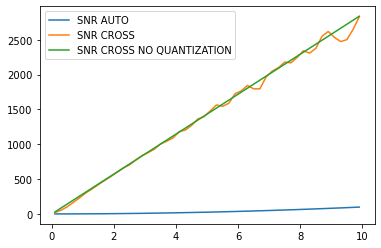

In [30]:
figure()
plot(gains, snr_auto, label='SNR AUTO')
plot(gains, snr_cross, label="SNR CROSS")
plot(gains, snr_cross_no_quant, label="SNR CROSS NO QUANTIZATION")
legend()

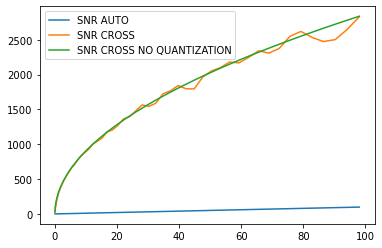

In [31]:
figure()
plot(gains*gains, snr_auto, label='SNR AUTO')
plot(gains*gains, snr_cross, label="SNR CROSS")
plot(gains*gains, snr_cross_no_quant, label="SNR CROSS NO QUANTIZATION")
legend()

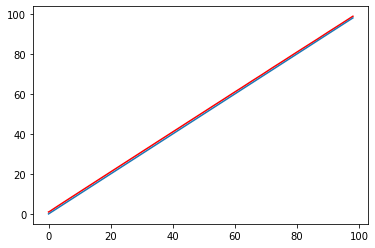

In [32]:
figure()
plot(gains*gains, snr_auto, color = 'red')
plot(gains*gains, gains*gains)
#SNR scales with power gain.

In [33]:
snr_cross_w_int = []
snr_cross_no_quant_w_int = []
snr_auto_w_int = []
stop_times = np.arange(5000,100000,5000)
gain=5.0
#prob should actually regenerate noise...
#make some fuctnios.
for stop_time in stop_times:
    #signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    f_signal_on = signal + noise_term/gain  #this way to make quantization easier
    f_signal_off = noise_term_off/gain
    q_signal_on = quantizer(f_signal_on, nbits=8)
    q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(q_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(q_signal_off[:stop_time])))
    cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    snr_cross_no_quant1 = abs(cross_corr_on_no_quant[0])/abs(cross_corr_off_no_quant[0])
    snr_cross1 = abs(cross_corr_on[0])/abs(cross_corr_off[0])
    snr_auto1 = (abs(auto_corr_on[0])-abs(auto_corr_off[0]))/abs(auto_corr_off[0])
    snr_cross_w_int.append(snr_cross1)
    snr_auto_w_int.append(snr_auto1)
    snr_cross_no_quant_w_int.append(snr_cross_no_quant1)
    print("int time {}, snr auto= {}, snr_cross={}, snr_cross_no_quant={}".format(stop_time, snr_auto1, snr_cross1, snr_cross_no_quant1))

int time 5000, snr auto= 24.52526046147312, snr_cross=418.97227383082594, snr_cross_no_quant=421.8984490589389
int time 10000, snr auto= 24.621764141610058, snr_cross=570.5306977481438, snr_cross_no_quant=566.8126548442677
int time 15000, snr auto= 24.96830504720901, snr_cross=638.7360223664416, snr_cross_no_quant=619.9067361165769
int time 20000, snr auto= 24.82991750944938, snr_cross=429.6079736648183, snr_cross_no_quant=427.48002734207626
int time 25000, snr auto= 24.883117746629807, snr_cross=523.2861346498808, snr_cross_no_quant=519.4418793727613
int time 30000, snr auto= 24.987146845444574, snr_cross=569.1837991409161, snr_cross_no_quant=565.8840344919917
int time 35000, snr auto= 24.982390015628994, snr_cross=565.6481533556395, snr_cross_no_quant=570.190157407095
int time 40000, snr auto= 25.107699370751035, snr_cross=656.3100686478954, snr_cross_no_quant=663.0754354944442
int time 45000, snr auto= 25.111863931782874, snr_cross=940.4966742763078, snr_cross_no_quant=938.110534714

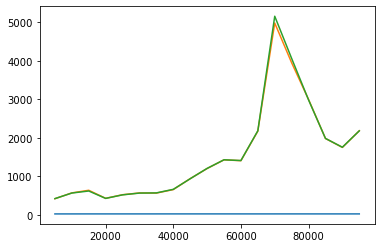

In [34]:
figure()
plot(stop_times, snr_auto_w_int)
plot(stop_times, snr_cross_w_int)
plot(stop_times, snr_cross_no_quant_w_int)

In [35]:
#Here we are trying to solve for the G.  If in total power, autos, then P_on is just a G proxy.  SNR sets an overall error term, and integration doesn't help that much.
#if switching on and off, then can get a G from (Pon-Poff)/(Ton-Toff) ratios.  Toff might be zero.
#Subtracting powers, gain error here will be decreasing as sqrt(time) with a sqrt(2) out front.
#for sim here using Ton=1 Toff=0 for simplicity.  

In [36]:
gains = np.arange(0.0005,0.5,0.0005)

In [37]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 1000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term_off = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= 7.491904247606271, gain_cross_no_quant=52.64152962187009
gain 0.001, gain auto= -116.70162879260465, gain_cross_no_quant=58.445579019954806
gain 0.0015, gain auto= 51.24316149758147, gain_cross_no_quant=-54.11477454665585
gain 0.002, gain auto= 11.167008793602918, gain_cross_no_quant=-25.64516538864228
gain 0.0025, gain auto= -54.89843301246742, gain_cross_no_quant=19.419255310007372
gain 0.003, gain auto= 51.633039676889666, gain_cross_no_quant=13.905433842272217
gain 0.0035, gain auto= 115.61949545711036, gain_cross_no_quant=-4.668838456826862
gain 0.004, gain auto= -31.703084169835165, gain_cross_no_quant=-25.955603584228548
gain 0.0045000000000000005, gain auto= 41.55767377533016, gain_cross_no_quant=53.290654822847685
gain 0.005000000000000001, gain auto= 1.4632534291656611, gain_cross_no_quant=-7.448955899764691
gain 0.0055, gain auto= -115.36823758174978, gain_cross_no_quant=-4.9258998065126605
gain 0.006, gain auto= 62.27534125596958, gain_cross_no_quant

gain 0.0495, gain auto= -127.95530005775754, gain_cross_no_quant=62.63804249749566
gain 0.05, gain auto= -38.290513419659646, gain_cross_no_quant=112.20960584510223
gain 0.0505, gain auto= 73.48995119512983, gain_cross_no_quant=137.86057122853393
gain 0.051000000000000004, gain auto= 33.88140751231958, gain_cross_no_quant=55.72629471685205
gain 0.051500000000000004, gain auto= -0.2839071038060865, gain_cross_no_quant=154.04427411746886
gain 0.052000000000000005, gain auto= -127.50809145971857, gain_cross_no_quant=54.34579656945891
gain 0.052500000000000005, gain auto= -99.58147715957648, gain_cross_no_quant=103.73932435495742
gain 0.053, gain auto= 19.96657664110785, gain_cross_no_quant=-13.259346127486879
gain 0.0535, gain auto= -60.257045197650996, gain_cross_no_quant=83.59815315721255
gain 0.054, gain auto= 111.27402426431445, gain_cross_no_quant=80.91360836473581
gain 0.0545, gain auto= 57.348644191443555, gain_cross_no_quant=69.88582249598089
gain 0.055, gain auto= -128.3522707423

gain 0.099, gain auto= 129.37397331376928, gain_cross_no_quant=193.93140265859694
gain 0.0995, gain auto= -113.25330888199983, gain_cross_no_quant=159.26942791517092
gain 0.1, gain auto= -23.453710527755902, gain_cross_no_quant=133.76480364038534
gain 0.1005, gain auto= 96.90753763637281, gain_cross_no_quant=182.0482468854456
gain 0.101, gain auto= 57.52771290919668, gain_cross_no_quant=80.70694561856536
gain 0.1015, gain auto= 52.347265008129625, gain_cross_no_quant=217.13147862291297
gain 0.10200000000000001, gain auto= 2.994597979898572, gain_cross_no_quant=193.23731253052273
gain 0.10250000000000001, gain auto= 77.31076782398691, gain_cross_no_quant=58.46661864187375
gain 0.10300000000000001, gain auto= 142.06557520054434, gain_cross_no_quant=91.7155842043254
gain 0.10350000000000001, gain auto= -275.34221995238545, gain_cross_no_quant=152.16269541077028
gain 0.10400000000000001, gain auto= 19.926705598220224, gain_cross_no_quant=162.52114232158084
gain 0.10450000000000001, gain au

gain 0.1505, gain auto= 154.00297626986662, gain_cross_no_quant=250.8483322084974
gain 0.151, gain auto= 48.741290134832525, gain_cross_no_quant=250.04290981761608
gain 0.1515, gain auto= -10.029675408856292, gain_cross_no_quant=272.6307371545455
gain 0.152, gain auto= -20.714335580063334, gain_cross_no_quant=243.62176746582597
gain 0.1525, gain auto= -75.54403330240666, gain_cross_no_quant=256.24993862711835
gain 0.153, gain auto= 8.543131550484759, gain_cross_no_quant=272.5199908404579
gain 0.1535, gain auto= 148.90909388947534, gain_cross_no_quant=283.4014341839166
gain 0.154, gain auto= 25.062712552490893, gain_cross_no_quant=294.2445852933108
gain 0.1545, gain auto= -19.885732825358218, gain_cross_no_quant=211.9232904134422
gain 0.155, gain auto= 113.37071793220571, gain_cross_no_quant=361.3953894707291
gain 0.1555, gain auto= -28.534139287402922, gain_cross_no_quant=302.8154884554454
gain 0.156, gain auto= 5.366250679067889, gain_cross_no_quant=135.0048756032534
gain 0.1565, gain

gain 0.20500000000000002, gain auto= 70.70960826757437, gain_cross_no_quant=386.2455417346589
gain 0.20550000000000002, gain auto= 41.920513161835515, gain_cross_no_quant=431.9610018863379
gain 0.20600000000000002, gain auto= 207.22283616407185, gain_cross_no_quant=462.7890219357626
gain 0.20650000000000002, gain auto= 161.3251709181875, gain_cross_no_quant=404.79349656845085
gain 0.20700000000000002, gain auto= 259.7168514438131, gain_cross_no_quant=463.5253070590496
gain 0.20750000000000002, gain auto= 173.54734220902606, gain_cross_no_quant=382.8249648691673
gain 0.20800000000000002, gain auto= -38.565281940568184, gain_cross_no_quant=338.5017623100688
gain 0.20850000000000002, gain auto= 109.37380414230915, gain_cross_no_quant=434.6949054885826
gain 0.209, gain auto= 110.00903450952569, gain_cross_no_quant=323.29813967426196
gain 0.2095, gain auto= 126.47444699611992, gain_cross_no_quant=282.4575631912348
gain 0.21, gain auto= 43.98375410804033, gain_cross_no_quant=393.310012033132

gain 0.2545, gain auto= 115.0612569807156, gain_cross_no_quant=509.7272604964511
gain 0.255, gain auto= 37.25372553229272, gain_cross_no_quant=432.57117606266104
gain 0.2555, gain auto= 69.27568800756353, gain_cross_no_quant=413.3630173371757
gain 0.256, gain auto= 107.20723295309108, gain_cross_no_quant=437.8679015596981
gain 0.2565, gain auto= 363.027642619639, gain_cross_no_quant=477.2327733017081
gain 0.257, gain auto= 125.6253148705207, gain_cross_no_quant=360.6432373954364
gain 0.2575, gain auto= 124.78629060098228, gain_cross_no_quant=433.0356097598627
gain 0.258, gain auto= 246.26343866511252, gain_cross_no_quant=544.4926214356802
gain 0.2585, gain auto= 141.1106344435227, gain_cross_no_quant=527.045624179698
gain 0.259, gain auto= 181.04871375455377, gain_cross_no_quant=418.09958403823805
gain 0.2595, gain auto= -30.002732605450774, gain_cross_no_quant=538.69071821262
gain 0.26, gain auto= 124.99388405265199, gain_cross_no_quant=454.7774636703652
gain 0.2605, gain auto= 73.784

gain 0.308, gain auto= -15.732080623185539, gain_cross_no_quant=416.4853730113736
gain 0.3085, gain auto= 265.73087614079964, gain_cross_no_quant=529.6900371188018
gain 0.309, gain auto= 105.40623789070992, gain_cross_no_quant=550.1386951845948
gain 0.3095, gain auto= 53.03558010898064, gain_cross_no_quant=566.6685896119482
gain 0.31, gain auto= 195.07728671073573, gain_cross_no_quant=639.4161181845999
gain 0.3105, gain auto= 175.63466776382006, gain_cross_no_quant=580.3107392264426
gain 0.311, gain auto= 262.4989751012754, gain_cross_no_quant=578.5802082319317
gain 0.3115, gain auto= 172.56140632784172, gain_cross_no_quant=565.0184408084791
gain 0.312, gain auto= 162.8561938149776, gain_cross_no_quant=521.5178575204777
gain 0.3125, gain auto= 273.77393258856523, gain_cross_no_quant=595.2251875670667
gain 0.313, gain auto= 240.20278696536866, gain_cross_no_quant=573.426392170373
gain 0.3135, gain auto= 265.2098258222345, gain_cross_no_quant=424.68871807974995
gain 0.314, gain auto= 281

gain 0.361, gain auto= 337.64767021006287, gain_cross_no_quant=755.4177256659682
gain 0.3615, gain auto= 310.4972734071248, gain_cross_no_quant=640.285527019314
gain 0.362, gain auto= 185.86996373046168, gain_cross_no_quant=698.996374799721
gain 0.3625, gain auto= 208.5699191503686, gain_cross_no_quant=709.4247028968241
gain 0.363, gain auto= 309.5182717634814, gain_cross_no_quant=744.0823527088025
gain 0.3635, gain auto= 333.77528751105274, gain_cross_no_quant=609.9129182737422
gain 0.364, gain auto= 273.64597381433646, gain_cross_no_quant=650.2238032100903
gain 0.3645, gain auto= 171.63694497311644, gain_cross_no_quant=679.4663788463265
gain 0.365, gain auto= 192.59675235288455, gain_cross_no_quant=630.3575535242686
gain 0.3655, gain auto= 278.6672057073499, gain_cross_no_quant=619.6102199279034
gain 0.366, gain auto= 310.5371369400689, gain_cross_no_quant=716.8070327047685
gain 0.3665, gain auto= 142.50972446491983, gain_cross_no_quant=636.2656782926764
gain 0.367, gain auto= 133.58

gain 0.41600000000000004, gain auto= 370.9514154029573, gain_cross_no_quant=737.2473357361142
gain 0.41650000000000004, gain auto= 237.32283739654235, gain_cross_no_quant=696.0335354077147
gain 0.417, gain auto= 298.6440284956409, gain_cross_no_quant=713.4840306309944
gain 0.4175, gain auto= 435.8468556409423, gain_cross_no_quant=807.1701157243264
gain 0.418, gain auto= 337.27481389428385, gain_cross_no_quant=809.23805977363
gain 0.4185, gain auto= 329.10854233293753, gain_cross_no_quant=715.4507786655729
gain 0.419, gain auto= 401.1175163170408, gain_cross_no_quant=788.5638638241358
gain 0.4195, gain auto= 259.64359156537785, gain_cross_no_quant=681.8519093541247
gain 0.42, gain auto= 251.8690756978442, gain_cross_no_quant=776.2114763262026
gain 0.4205, gain auto= 329.2519473366565, gain_cross_no_quant=766.628306515426
gain 0.421, gain auto= 186.43606369293457, gain_cross_no_quant=793.166951629618
gain 0.4215, gain auto= 320.9151087190189, gain_cross_no_quant=790.4317729473714
gain 0.

gain 0.47000000000000003, gain auto= 235.90991182764765, gain_cross_no_quant=755.4175385202899
gain 0.47050000000000003, gain auto= 529.0815949708594, gain_cross_no_quant=946.2349431401094
gain 0.47100000000000003, gain auto= 220.943924770595, gain_cross_no_quant=871.2310450466298
gain 0.47150000000000003, gain auto= 427.67596918242543, gain_cross_no_quant=933.342162433029
gain 0.47200000000000003, gain auto= 314.51123330389737, gain_cross_no_quant=804.1627217081877
gain 0.47250000000000003, gain auto= 526.279752591463, gain_cross_no_quant=880.7715135162658
gain 0.47300000000000003, gain auto= 399.9305676097215, gain_cross_no_quant=805.8750837366572
gain 0.47350000000000003, gain auto= 388.6885892779153, gain_cross_no_quant=851.3024192111461
gain 0.47400000000000003, gain auto= 434.28909518725004, gain_cross_no_quant=868.3392738081052
gain 0.47450000000000003, gain auto= 460.8154322207797, gain_cross_no_quant=861.5899769496584
gain 0.47500000000000003, gain auto= 485.0648442955255, gai

In [38]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

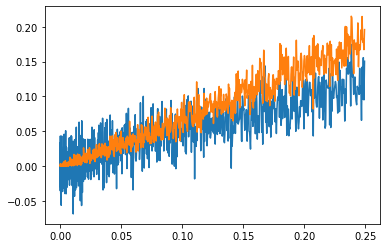

In [39]:
figure()
plot(gains*gains, gain_auto/4e3)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/5e6)

In [40]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 4096
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term_off = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= 70.52266068898825, gain_cross_no_quant=-99.10126663000305
gain 0.001, gain auto= -217.04650421960105, gain_cross_no_quant=-52.78413922502877
gain 0.0015, gain auto= 17.12487199921179, gain_cross_no_quant=-6.896155504285787
gain 0.002, gain auto= -364.40203464889237, gain_cross_no_quant=-53.07223455394717
gain 0.0025, gain auto= -18.843145320051917, gain_cross_no_quant=176.32936426760725
gain 0.003, gain auto= -110.18444649613775, gain_cross_no_quant=-28.768655701189942
gain 0.0035, gain auto= -264.8062277734889, gain_cross_no_quant=133.22148578232384
gain 0.004, gain auto= -86.07745659951888, gain_cross_no_quant=204.26262298115185
gain 0.0045000000000000005, gain auto= -103.57064459436151, gain_cross_no_quant=73.53824645031472
gain 0.005000000000000001, gain auto= 255.63049370212048, gain_cross_no_quant=-4.4649607177616275
gain 0.0055, gain auto= 31.25517773822503, gain_cross_no_quant=-62.48102491708423
gain 0.006, gain auto= -120.60444081261085, gain_cross_no_q

gain 0.052500000000000005, gain auto= -69.95254920040861, gain_cross_no_quant=467.2651114193941
gain 0.053, gain auto= 105.49139793801805, gain_cross_no_quant=325.2195425979337
gain 0.0535, gain auto= 9.799477871780255, gain_cross_no_quant=181.9719247813837
gain 0.054, gain auto= -21.592344768136172, gain_cross_no_quant=319.28671777965195
gain 0.0545, gain auto= 53.50554843586542, gain_cross_no_quant=407.91425097234674
gain 0.055, gain auto= -331.82851083030437, gain_cross_no_quant=229.52010778935698
gain 0.0555, gain auto= 158.89955746577834, gain_cross_no_quant=511.27531052458676
gain 0.056, gain auto= -69.28735660498569, gain_cross_no_quant=438.44373881325726
gain 0.0565, gain auto= 12.58805095896787, gain_cross_no_quant=414.8528411386545
gain 0.057, gain auto= -54.19969433088954, gain_cross_no_quant=296.3385687073413
gain 0.0575, gain auto= -172.34087721143987, gain_cross_no_quant=202.6005315019213
gain 0.058, gain auto= -128.47408891379746, gain_cross_no_quant=294.60671456215016
g

gain 0.10350000000000001, gain auto= 306.78198103747854, gain_cross_no_quant=856.206217526435
gain 0.10400000000000001, gain auto= 347.8134139814483, gain_cross_no_quant=679.9801700059027
gain 0.10450000000000001, gain auto= -276.82118678390543, gain_cross_no_quant=661.2095143807119
gain 0.105, gain auto= 105.11395600323885, gain_cross_no_quant=716.1827853497454
gain 0.1055, gain auto= -314.43474858909485, gain_cross_no_quant=598.7032117903353
gain 0.106, gain auto= -39.618049052097376, gain_cross_no_quant=565.260241703042
gain 0.1065, gain auto= 205.93338435000715, gain_cross_no_quant=875.8082465276825
gain 0.107, gain auto= 185.97598771290905, gain_cross_no_quant=834.122033989678
gain 0.1075, gain auto= 146.81387112518496, gain_cross_no_quant=699.4358907903189
gain 0.108, gain auto= 86.47359034179863, gain_cross_no_quant=837.2561196193034
gain 0.1085, gain auto= -156.3394319296949, gain_cross_no_quant=863.976074667628
gain 0.109, gain auto= -121.86818583386321, gain_cross_no_quant=69

gain 0.153, gain auto= 208.62252461004846, gain_cross_no_quant=1163.4332728979268
gain 0.1535, gain auto= 408.558304691036, gain_cross_no_quant=1097.2384412102704
gain 0.154, gain auto= 201.08646213737848, gain_cross_no_quant=1073.6929160608818
gain 0.1545, gain auto= 364.82950034018904, gain_cross_no_quant=1190.6854011403107
gain 0.155, gain auto= 261.5301367750253, gain_cross_no_quant=1219.659233585724
gain 0.1555, gain auto= 49.51956039225843, gain_cross_no_quant=1226.4392831571017
gain 0.156, gain auto= -277.2338522372884, gain_cross_no_quant=1188.820444950043
gain 0.1565, gain auto= 346.6248526850204, gain_cross_no_quant=1198.4309152851083
gain 0.157, gain auto= 504.1940844959345, gain_cross_no_quant=1331.3894021614217
gain 0.1575, gain auto= 325.2137808102525, gain_cross_no_quant=1297.9341924708663
gain 0.158, gain auto= 451.0054339014896, gain_cross_no_quant=1238.5137965170213
gain 0.1585, gain auto= 39.056911446250524, gain_cross_no_quant=1128.6061657854857
gain 0.159, gain aut

gain 0.20450000000000002, gain auto= 354.5462403926831, gain_cross_no_quant=1497.4534895641414
gain 0.20500000000000002, gain auto= 245.66766443930283, gain_cross_no_quant=1608.7578643867112
gain 0.20550000000000002, gain auto= 237.36346481195142, gain_cross_no_quant=1473.1040597224699
gain 0.20600000000000002, gain auto= 388.7457314309595, gain_cross_no_quant=1627.2816195187659
gain 0.20650000000000002, gain auto= 317.88413921517895, gain_cross_no_quant=1613.3620014872304
gain 0.20700000000000002, gain auto= 477.4842242414052, gain_cross_no_quant=1597.9060452356127
gain 0.20750000000000002, gain auto= 345.2664079175938, gain_cross_no_quant=1610.1745655189022
gain 0.20800000000000002, gain auto= 436.3563877739307, gain_cross_no_quant=1589.4777983647093
gain 0.20850000000000002, gain auto= 159.86487824831056, gain_cross_no_quant=1556.4013090506896
gain 0.209, gain auto= 170.5305553222879, gain_cross_no_quant=1565.4261097136969
gain 0.2095, gain auto= 577.8355864323603, gain_cross_no_qua

gain 0.2535, gain auto= 941.0434770384636, gain_cross_no_quant=1802.9364651169008
gain 0.254, gain auto= 696.182840051516, gain_cross_no_quant=2072.4860247980337
gain 0.2545, gain auto= 872.4995812095331, gain_cross_no_quant=2216.4804120709086
gain 0.255, gain auto= 630.7162847321051, gain_cross_no_quant=2132.854362171799
gain 0.2555, gain auto= 410.37020844446124, gain_cross_no_quant=1958.493639299152
gain 0.256, gain auto= 337.77994600689453, gain_cross_no_quant=1943.847685423436
gain 0.2565, gain auto= 738.3827090829163, gain_cross_no_quant=2030.1703506440217
gain 0.257, gain auto= 671.2011636480511, gain_cross_no_quant=1905.1268062911583
gain 0.2575, gain auto= 530.8795605170926, gain_cross_no_quant=2130.436518589219
gain 0.258, gain auto= 525.5950716251355, gain_cross_no_quant=2046.027957688676
gain 0.2585, gain auto= 906.793352028355, gain_cross_no_quant=2059.609060690907
gain 0.259, gain auto= 655.1350270732364, gain_cross_no_quant=2157.594186760302
gain 0.2595, gain auto= 274.4

gain 0.303, gain auto= 763.751902439777, gain_cross_no_quant=2335.0368130663733
gain 0.3035, gain auto= 633.3849125949855, gain_cross_no_quant=2229.370205908672
gain 0.304, gain auto= 951.486410112997, gain_cross_no_quant=2560.8667968925215
gain 0.3045, gain auto= 783.2402297346307, gain_cross_no_quant=2421.894248573006
gain 0.305, gain auto= 1145.5454620489054, gain_cross_no_quant=2213.773536187398
gain 0.3055, gain auto= 868.808874318057, gain_cross_no_quant=2298.965806557231
gain 0.306, gain auto= 930.6052129717264, gain_cross_no_quant=2285.0244032957157
gain 0.3065, gain auto= 622.8611565127994, gain_cross_no_quant=2429.3777307987275
gain 0.307, gain auto= 695.2085592357607, gain_cross_no_quant=2297.2698506655574
gain 0.3075, gain auto= 934.5387075672825, gain_cross_no_quant=2359.7338519371674
gain 0.308, gain auto= 620.0361709622775, gain_cross_no_quant=2481.1124249917384
gain 0.3085, gain auto= 753.981339203976, gain_cross_no_quant=2500.5318859086833
gain 0.309, gain auto= 458.73

gain 0.354, gain auto= 1281.8567568302715, gain_cross_no_quant=3053.9165327522605
gain 0.3545, gain auto= 861.2285794727177, gain_cross_no_quant=2679.3103324641916
gain 0.355, gain auto= 1005.6879209725585, gain_cross_no_quant=2848.3994187566836
gain 0.3555, gain auto= 1257.6591579992273, gain_cross_no_quant=2995.068132935055
gain 0.356, gain auto= 665.723578314577, gain_cross_no_quant=2785.4794451043804
gain 0.3565, gain auto= 796.2527582147122, gain_cross_no_quant=2676.001373606293
gain 0.357, gain auto= 1024.4004331778197, gain_cross_no_quant=2652.3451236574374
gain 0.3575, gain auto= 934.8527761549012, gain_cross_no_quant=2841.252136197435
gain 0.358, gain auto= 812.3755212133456, gain_cross_no_quant=2727.0613321657306
gain 0.3585, gain auto= 1066.735247216966, gain_cross_no_quant=2837.43852398946
gain 0.359, gain auto= 1504.0396899051748, gain_cross_no_quant=3032.4329548169867
gain 0.3595, gain auto= 988.0253113131403, gain_cross_no_quant=2876.5872991374417
gain 0.36, gain auto= 8

gain 0.40850000000000003, gain auto= 1303.2097851839135, gain_cross_no_quant=3233.157754849063
gain 0.40900000000000003, gain auto= 1330.559041524668, gain_cross_no_quant=3051.277603062741
gain 0.40950000000000003, gain auto= 1442.3242647751795, gain_cross_no_quant=3414.413416927981
gain 0.41000000000000003, gain auto= 1481.7888855429192, gain_cross_no_quant=3265.5595076785485
gain 0.41050000000000003, gain auto= 1299.946107477862, gain_cross_no_quant=3009.2169550846706
gain 0.41100000000000003, gain auto= 1534.6436951726737, gain_cross_no_quant=3293.3610984913607
gain 0.41150000000000003, gain auto= 1334.7166184213183, gain_cross_no_quant=3222.12167767465
gain 0.41200000000000003, gain auto= 1610.2153801669829, gain_cross_no_quant=3427.4944389928587
gain 0.41250000000000003, gain auto= 1641.7868789350896, gain_cross_no_quant=3269.0551264190217
gain 0.41300000000000003, gain auto= 1267.378929951441, gain_cross_no_quant=3207.0726447052266
gain 0.41350000000000003, gain auto= 1021.638637

gain 0.4605, gain auto= 1857.350963688632, gain_cross_no_quant=3633.633975395777
gain 0.461, gain auto= 1723.6497339730959, gain_cross_no_quant=3481.7064434505437
gain 0.4615, gain auto= 1877.5658803161505, gain_cross_no_quant=3687.0603009811844
gain 0.462, gain auto= 1932.7875149737392, gain_cross_no_quant=3947.1833255938827
gain 0.4625, gain auto= 1722.7009147149129, gain_cross_no_quant=3369.589377684148
gain 0.463, gain auto= 1700.1760101290838, gain_cross_no_quant=3526.7798053045317
gain 0.4635, gain auto= 1615.5496305582856, gain_cross_no_quant=3873.204933380131
gain 0.464, gain auto= 1873.887114741803, gain_cross_no_quant=3565.808094280794
gain 0.4645, gain auto= 1560.2132664720712, gain_cross_no_quant=3647.823195398126
gain 0.465, gain auto= 1697.2188567695557, gain_cross_no_quant=3656.742630579464
gain 0.4655, gain auto= 1644.6797742661383, gain_cross_no_quant=3669.769097592541
gain 0.466, gain auto= 1576.5428393253733, gain_cross_no_quant=3506.5511421026617
gain 0.4665, gain a

In [41]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

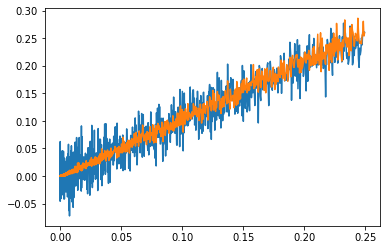

In [42]:
figure()
plot(gains*gains, gain_auto/8e3)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/6e7)

In [43]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 100000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    noise_term = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= 624.7851207450585, gain_cross_no_quant=-119.09932093132525
gain 0.001, gain auto= -611.3675157287216, gain_cross_no_quant=-184.7790458520605
gain 0.0015, gain auto= -328.22552794641524, gain_cross_no_quant=-259.51289756950086
gain 0.002, gain auto= -423.6574704139639, gain_cross_no_quant=43.275546375126396
gain 0.0025, gain auto= 40.64753108531295, gain_cross_no_quant=232.55143819172588
gain 0.003, gain auto= 83.51590854517417, gain_cross_no_quant=192.62322821942695
gain 0.0035, gain auto= 648.3058519871411, gain_cross_no_quant=137.85763270969133
gain 0.004, gain auto= -181.8620005728444, gain_cross_no_quant=200.27349844703014
gain 0.0045000000000000005, gain auto= 134.91155157024332, gain_cross_no_quant=80.26715400341453
gain 0.005000000000000001, gain auto= -886.8131698854995, gain_cross_no_quant=513.7152564399602
gain 0.0055, gain auto= 558.4381331508484, gain_cross_no_quant=307.5894445365873
gain 0.006, gain auto= 1072.0846119697671, gain_cross_no_quant=358.

gain 0.05, gain auto= -1066.7531668923184, gain_cross_no_quant=4769.431007943358
gain 0.0505, gain auto= 447.9558412094484, gain_cross_no_quant=4719.801835136807
gain 0.051000000000000004, gain auto= 8.344938351641758, gain_cross_no_quant=4601.9977166987655
gain 0.051500000000000004, gain auto= -388.59930635597266, gain_cross_no_quant=4850.998979894168
gain 0.052000000000000005, gain auto= 1120.4169913590595, gain_cross_no_quant=5356.5060726676675
gain 0.052500000000000005, gain auto= 549.7855673942104, gain_cross_no_quant=5097.736975182617
gain 0.053, gain auto= 711.3080878719338, gain_cross_no_quant=4957.470612759476
gain 0.0535, gain auto= 197.9189935203758, gain_cross_no_quant=5011.0882936312455
gain 0.054, gain auto= 461.7347199892247, gain_cross_no_quant=5045.183944407727
gain 0.0545, gain auto= 772.7742898368888, gain_cross_no_quant=5045.084522632456
gain 0.055, gain auto= 471.1181126150914, gain_cross_no_quant=4804.147230762662
gain 0.0555, gain auto= 541.6693346629763, gain_cr

gain 0.1, gain auto= 1236.0723624796083, gain_cross_no_quant=9924.249292923327
gain 0.1005, gain auto= 1198.1646427673986, gain_cross_no_quant=9688.55515950949
gain 0.101, gain auto= 989.6187621380814, gain_cross_no_quant=10172.879250794831
gain 0.1015, gain auto= 1154.2737155141367, gain_cross_no_quant=10161.133702048046
gain 0.10200000000000001, gain auto= 1549.232221103055, gain_cross_no_quant=9710.262887117213
gain 0.10250000000000001, gain auto= 163.8179446961003, gain_cross_no_quant=9795.762216930165
gain 0.10300000000000001, gain auto= 343.6379263619456, gain_cross_no_quant=9731.944561897682
gain 0.10350000000000001, gain auto= 695.8021188003331, gain_cross_no_quant=9993.28660091005
gain 0.10400000000000001, gain auto= 1281.6083323892817, gain_cross_no_quant=9892.928229283116
gain 0.10450000000000001, gain auto= 900.1653003853135, gain_cross_no_quant=10307.613051951937
gain 0.105, gain auto= 681.0084538888041, gain_cross_no_quant=10740.109492047868
gain 0.1055, gain auto= 589.12

gain 0.15, gain auto= 522.0792697081633, gain_cross_no_quant=15375.792822592284
gain 0.1505, gain auto= 1962.9923056655243, gain_cross_no_quant=14968.250737823346
gain 0.151, gain auto= 1812.520075921304, gain_cross_no_quant=15107.732620011371
gain 0.1515, gain auto= 1534.1309808828082, gain_cross_no_quant=14911.510614790783
gain 0.152, gain auto= 1875.5151255653327, gain_cross_no_quant=15019.352519730426
gain 0.1525, gain auto= 2342.760235577589, gain_cross_no_quant=14925.369287724228
gain 0.153, gain auto= 3317.125538261229, gain_cross_no_quant=14854.629411652077
gain 0.1535, gain auto= 2291.2274870338733, gain_cross_no_quant=14974.59772610636
gain 0.154, gain auto= 2806.488381181043, gain_cross_no_quant=15397.661234441579
gain 0.1545, gain auto= 2498.7782082710037, gain_cross_no_quant=15318.681080406855
gain 0.155, gain auto= 3147.9255382129486, gain_cross_no_quant=15624.083641964267
gain 0.1555, gain auto= 1574.7556357185967, gain_cross_no_quant=15087.02974680048
gain 0.156, gain a

gain 0.1995, gain auto= 3888.365777957195, gain_cross_no_quant=20196.355512547285
gain 0.2, gain auto= 4124.102498518376, gain_cross_no_quant=19962.895515071454
gain 0.2005, gain auto= 3594.265363153303, gain_cross_no_quant=19292.77776746954
gain 0.201, gain auto= 3705.4262714556244, gain_cross_no_quant=19351.47423922528
gain 0.2015, gain auto= 3930.367655384165, gain_cross_no_quant=20249.958378473813
gain 0.202, gain auto= 4192.321221169186, gain_cross_no_quant=19829.833207543878
gain 0.2025, gain auto= 3765.9188411465875, gain_cross_no_quant=19576.774366858084
gain 0.203, gain auto= 4214.314998941758, gain_cross_no_quant=20519.427626503726
gain 0.20350000000000001, gain auto= 4302.48837576418, gain_cross_no_quant=20066.226573453743
gain 0.20400000000000001, gain auto= 3497.5501848336717, gain_cross_no_quant=19948.075155892184
gain 0.20450000000000002, gain auto= 3948.5781523910555, gain_cross_no_quant=20380.014397899253
gain 0.20500000000000002, gain auto= 4159.831364281024, gain_cro

gain 0.2485, gain auto= 5963.875187418787, gain_cross_no_quant=24917.245066570857
gain 0.249, gain auto= 5769.1424642064085, gain_cross_no_quant=24523.70977033923
gain 0.2495, gain auto= 6665.623949695757, gain_cross_no_quant=25127.21257085201
gain 0.25, gain auto= 6481.700934498556, gain_cross_no_quant=24707.2686322641
gain 0.2505, gain auto= 6356.973644829952, gain_cross_no_quant=24532.40913223072
gain 0.251, gain auto= 6502.5376840104145, gain_cross_no_quant=24786.265888786147
gain 0.2515, gain auto= 6214.934210042571, gain_cross_no_quant=24622.516553942205
gain 0.252, gain auto= 6612.70868841726, gain_cross_no_quant=25173.07183731872
gain 0.2525, gain auto= 6528.166877792159, gain_cross_no_quant=25066.048382943325
gain 0.253, gain auto= 5582.499151841868, gain_cross_no_quant=24646.676292745324
gain 0.2535, gain auto= 6517.982286540719, gain_cross_no_quant=25129.906193224728
gain 0.254, gain auto= 6166.8419359071995, gain_cross_no_quant=24738.001269146516
gain 0.2545, gain auto= 688

gain 0.298, gain auto= 8994.775512497057, gain_cross_no_quant=29409.23109287014
gain 0.2985, gain auto= 9356.029540691132, gain_cross_no_quant=29201.657053595285
gain 0.299, gain auto= 8536.030625577027, gain_cross_no_quant=29744.0009340009
gain 0.2995, gain auto= 8784.823365477525, gain_cross_no_quant=29684.431134853934
gain 0.3, gain auto= 8436.852234890597, gain_cross_no_quant=29658.24927194007
gain 0.3005, gain auto= 8584.314607419743, gain_cross_no_quant=29670.438269791957
gain 0.301, gain auto= 9047.658206811539, gain_cross_no_quant=29860.915781586984
gain 0.3015, gain auto= 8835.577731993413, gain_cross_no_quant=30335.90106837772
gain 0.302, gain auto= 8703.185502547713, gain_cross_no_quant=30083.864942030523
gain 0.3025, gain auto= 9163.461508765991, gain_cross_no_quant=29944.44087454142
gain 0.303, gain auto= 8826.06687727914, gain_cross_no_quant=29522.007262683815
gain 0.3035, gain auto= 8276.936833976797, gain_cross_no_quant=29787.685075796308
gain 0.304, gain auto= 8974.526

gain 0.34900000000000003, gain auto= 11972.845718193275, gain_cross_no_quant=34601.04321434059
gain 0.34950000000000003, gain auto= 11873.026355832932, gain_cross_no_quant=34469.53566212244
gain 0.35000000000000003, gain auto= 11958.76884249982, gain_cross_no_quant=34892.031872635715
gain 0.35050000000000003, gain auto= 12930.574236358807, gain_cross_no_quant=35020.25781140517
gain 0.35100000000000003, gain auto= 12396.424161649178, gain_cross_no_quant=34556.0129230873
gain 0.35150000000000003, gain auto= 12565.501552943038, gain_cross_no_quant=34339.69888155312
gain 0.35200000000000004, gain auto= 12124.822159682575, gain_cross_no_quant=34578.03146919847
gain 0.3525, gain auto= 12819.351290468447, gain_cross_no_quant=34724.392047957175
gain 0.353, gain auto= 11477.661671463502, gain_cross_no_quant=34705.58941060481
gain 0.3535, gain auto= 12697.753103241237, gain_cross_no_quant=34887.98057508028
gain 0.354, gain auto= 12100.468295968181, gain_cross_no_quant=34777.12215062681
gain 0.35

gain 0.4, gain auto= 16546.44664957936, gain_cross_no_quant=39642.15719965122
gain 0.4005, gain auto= 16361.624076089865, gain_cross_no_quant=39486.60315021021
gain 0.401, gain auto= 15883.706213297992, gain_cross_no_quant=39534.209287344915
gain 0.4015, gain auto= 15990.610336161044, gain_cross_no_quant=39666.17990586686
gain 0.402, gain auto= 16710.817537260387, gain_cross_no_quant=40224.807483599005
gain 0.4025, gain auto= 16227.112561073038, gain_cross_no_quant=39909.71142345121
gain 0.403, gain auto= 16313.503920509538, gain_cross_no_quant=40132.49605438984
gain 0.4035, gain auto= 16713.284554991653, gain_cross_no_quant=39615.32725998812
gain 0.404, gain auto= 16267.290547675133, gain_cross_no_quant=40436.95449008449
gain 0.4045, gain auto= 16590.210191463033, gain_cross_no_quant=40939.620047828146
gain 0.405, gain auto= 16753.88648411176, gain_cross_no_quant=39614.47830035802
gain 0.4055, gain auto= 16390.594541889004, gain_cross_no_quant=40394.1067402856
gain 0.406, gain auto= 1

gain 0.45, gain auto= 19970.707980912106, gain_cross_no_quant=44853.928827728516
gain 0.4505, gain auto= 20560.89924088359, gain_cross_no_quant=45171.869535705395
gain 0.451, gain auto= 20599.3099175182, gain_cross_no_quant=45243.13915864286
gain 0.4515, gain auto= 21193.11874591207, gain_cross_no_quant=45069.10869088743
gain 0.452, gain auto= 20218.08435420887, gain_cross_no_quant=44664.464594695826
gain 0.4525, gain auto= 20287.889513398113, gain_cross_no_quant=45259.04974453021
gain 0.453, gain auto= 20119.914613744215, gain_cross_no_quant=45045.241168823624
gain 0.4535, gain auto= 20335.545732479135, gain_cross_no_quant=45315.62455580833
gain 0.454, gain auto= 21685.562888290835, gain_cross_no_quant=45218.17102778232
gain 0.4545, gain auto= 20388.323235483927, gain_cross_no_quant=44823.0690845936
gain 0.455, gain auto= 20566.956836096288, gain_cross_no_quant=45319.52311294922
gain 0.4555, gain auto= 21281.111936474204, gain_cross_no_quant=45846.483080123595
gain 0.456, gain auto= 2

In [44]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

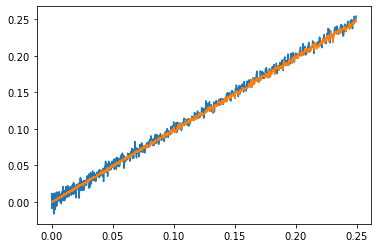

In [45]:
figure()
plot(gains*gains, gain_auto/1e5)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e5/1e5)

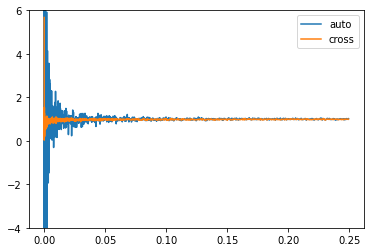

In [46]:
figure()
plot(gains*gains, gain_auto/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e10/(gains*gains), label="cross")  #4e10
ylim(-4,6)
legend()

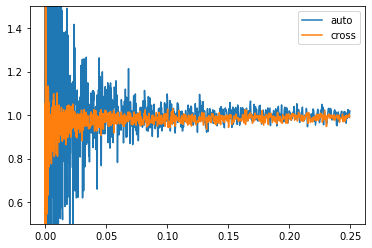

In [47]:
figure()
plot(gains*gains, gain_auto/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [48]:
gains = np.arange(0.05,1,0.05)
n_gains = len(gains)
repeats = 100
stop_time = 100000
gain_cross_no_quant = np.zeros((repeats,n_gains))
gain_auto = np.zeros((repeats,n_gains))


for i,gain in enumerate(gains):
    for j in np.arange(repeats):
        signal = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        f_signal_on = gain*signal + noise_term  #this way to make quantization easier
        f_signal_off = noise_term_off
        #q_signal_on = quantizer(f_signal_on, nbits=8)
        #q_signal_off = quantizer(f_signal_off, nbits=8)
        #q_signal_on = f_signal_on
        #q_signal_off = f_signal_off
        auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
        auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
        #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
        #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
        gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
        #gain_cross.append(gain_cross1)
        gain_auto[j,i] = gain_auto1
        gain_cross_no_quant[j,i] = gain_cross_no_quant1
        print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.05, gain auto= 176.04056694319297, gain_cross_no_quant=4570.1327519534525
gain 0.05, gain auto= 140.3612879656721, gain_cross_no_quant=4755.972320719621
gain 0.05, gain auto= 212.54178549876087, gain_cross_no_quant=4686.039687358917
gain 0.05, gain auto= 27.58585149575083, gain_cross_no_quant=5100.30091442467
gain 0.05, gain auto= 329.4407527381263, gain_cross_no_quant=4873.170462245201
gain 0.05, gain auto= 395.7098280742939, gain_cross_no_quant=4757.111477510584
gain 0.05, gain auto= -526.6980026519886, gain_cross_no_quant=4783.516180576261
gain 0.05, gain auto= 633.4599482044723, gain_cross_no_quant=5152.62821111527
gain 0.05, gain auto= -83.61189746562741, gain_cross_no_quant=5221.719379897146
gain 0.05, gain auto= 410.3055602826935, gain_cross_no_quant=4454.257212529499
gain 0.05, gain auto= -202.11078541370807, gain_cross_no_quant=4570.978814926791
gain 0.05, gain auto= 519.4217906244594, gain_cross_no_quant=5089.3657123038465
gain 0.05, gain auto= 992.1266022603959, gain_

gain 0.1, gain auto= 967.8651399285154, gain_cross_no_quant=9864.321185459892
gain 0.1, gain auto= 873.5655692121509, gain_cross_no_quant=9701.069316983541
gain 0.1, gain auto= 536.7591844496346, gain_cross_no_quant=9629.139071818576
gain 0.1, gain auto= 716.3483445381717, gain_cross_no_quant=9586.62753761127
gain 0.1, gain auto= 1098.9786056048615, gain_cross_no_quant=10260.011214785613
gain 0.1, gain auto= 1243.5634356636874, gain_cross_no_quant=9968.496317663099
gain 0.1, gain auto= 333.50254914481775, gain_cross_no_quant=9963.827950992987
gain 0.1, gain auto= 1054.6829590764537, gain_cross_no_quant=9719.970582532096
gain 0.1, gain auto= 1149.6154122427833, gain_cross_no_quant=8947.799978732062
gain 0.1, gain auto= 318.8372059397225, gain_cross_no_quant=9752.992833777707
gain 0.1, gain auto= 332.7390430082014, gain_cross_no_quant=9585.383133536014
gain 0.1, gain auto= 834.6777597292676, gain_cross_no_quant=9659.633559328455
gain 0.1, gain auto= 890.9255710465659, gain_cross_no_quant

gain 0.15000000000000002, gain auto= 2389.356546307885, gain_cross_no_quant=15554.860015879513
gain 0.15000000000000002, gain auto= 2430.3017624772474, gain_cross_no_quant=14685.41244399613
gain 0.15000000000000002, gain auto= 1962.6234890748892, gain_cross_no_quant=14622.922083004547
gain 0.15000000000000002, gain auto= 2574.7976904297248, gain_cross_no_quant=14693.73579973593
gain 0.15000000000000002, gain auto= 2357.638721311785, gain_cross_no_quant=14556.6004740438
gain 0.15000000000000002, gain auto= 2376.3320077096723, gain_cross_no_quant=15155.020831311213
gain 0.15000000000000002, gain auto= 2093.139038028574, gain_cross_no_quant=14178.110149216089
gain 0.15000000000000002, gain auto= 2500.3137871530926, gain_cross_no_quant=14996.02457574261
gain 0.15000000000000002, gain auto= 2200.1878086759534, gain_cross_no_quant=14874.354739504799
gain 0.15000000000000002, gain auto= 2536.284675988849, gain_cross_no_quant=14512.914935519202
gain 0.15000000000000002, gain auto= 2486.0324833

gain 0.15000000000000002, gain auto= 2694.5381449703273, gain_cross_no_quant=14317.010067644733
gain 0.15000000000000002, gain auto= 2891.716216788598, gain_cross_no_quant=14935.372360475192
gain 0.15000000000000002, gain auto= 1743.682420160927, gain_cross_no_quant=14258.785089805444
gain 0.2, gain auto= 3626.648304984148, gain_cross_no_quant=19633.591727670482
gain 0.2, gain auto= 3905.682440053046, gain_cross_no_quant=19264.75807421422
gain 0.2, gain auto= 3692.967918970142, gain_cross_no_quant=19383.82368321756
gain 0.2, gain auto= 3464.481474079046, gain_cross_no_quant=19457.81392102562
gain 0.2, gain auto= 4176.317767987319, gain_cross_no_quant=19512.076747902647
gain 0.2, gain auto= 4429.66370700761, gain_cross_no_quant=19691.3021633537
gain 0.2, gain auto= 4122.003687853372, gain_cross_no_quant=19669.25647024704
gain 0.2, gain auto= 4439.9754050185875, gain_cross_no_quant=19851.239547361
gain 0.2, gain auto= 3893.685042504483, gain_cross_no_quant=19549.476923237187
gain 0.2, ga

gain 0.25, gain auto= 6236.822987641848, gain_cross_no_quant=24646.091169008116
gain 0.25, gain auto= 6048.404714037257, gain_cross_no_quant=24638.612890882807
gain 0.25, gain auto= 5442.673193347713, gain_cross_no_quant=24829.647407549564
gain 0.25, gain auto= 6157.777575285931, gain_cross_no_quant=24683.471495727328
gain 0.25, gain auto= 6212.273514378219, gain_cross_no_quant=25074.492665292375
gain 0.25, gain auto= 6244.188086865368, gain_cross_no_quant=24817.834390061573
gain 0.25, gain auto= 6513.065207539374, gain_cross_no_quant=24669.952370837644
gain 0.25, gain auto= 6587.292248118247, gain_cross_no_quant=24950.8457393909
gain 0.25, gain auto= 5652.429405437724, gain_cross_no_quant=24850.762799766642
gain 0.25, gain auto= 6166.365458988541, gain_cross_no_quant=25160.032912675728
gain 0.25, gain auto= 5845.4185775624355, gain_cross_no_quant=24479.117969312556
gain 0.25, gain auto= 6430.581256859397, gain_cross_no_quant=24560.437863211864
gain 0.25, gain auto= 7276.28146428836, g

gain 0.3, gain auto= 9165.036994593785, gain_cross_no_quant=29572.86537782191
gain 0.3, gain auto= 9163.439961858778, gain_cross_no_quant=28805.609157855157
gain 0.3, gain auto= 9358.52066890402, gain_cross_no_quant=29692.388615429325
gain 0.3, gain auto= 9417.341351260475, gain_cross_no_quant=29906.924660354052
gain 0.3, gain auto= 8721.868230715074, gain_cross_no_quant=29912.52341892334
gain 0.3, gain auto= 7945.685129373189, gain_cross_no_quant=29776.296792688623
gain 0.3, gain auto= 8879.377856324398, gain_cross_no_quant=29112.431739927095
gain 0.3, gain auto= 8755.31226095045, gain_cross_no_quant=29295.180887569357
gain 0.3, gain auto= 9180.262700922656, gain_cross_no_quant=29542.405260676886
gain 0.3, gain auto= 8941.696509837668, gain_cross_no_quant=29593.973818543716
gain 0.3, gain auto= 8706.670257010774, gain_cross_no_quant=29181.736374380893
gain 0.3, gain auto= 9544.908009698978, gain_cross_no_quant=29284.895717002848
gain 0.3, gain auto= 9042.31380619538, gain_cross_no_qua

gain 0.35000000000000003, gain auto= 11686.383301801077, gain_cross_no_quant=34773.07322069602
gain 0.35000000000000003, gain auto= 12557.427149378665, gain_cross_no_quant=34618.623075915864
gain 0.35000000000000003, gain auto= 12438.001977521359, gain_cross_no_quant=34555.407351696915
gain 0.35000000000000003, gain auto= 12511.801542059853, gain_cross_no_quant=35273.66088144028
gain 0.35000000000000003, gain auto= 12309.021427022803, gain_cross_no_quant=34193.32018818471
gain 0.35000000000000003, gain auto= 12903.384224378737, gain_cross_no_quant=34618.41715858733
gain 0.35000000000000003, gain auto= 11918.666762227309, gain_cross_no_quant=34681.63263103528
gain 0.35000000000000003, gain auto= 11880.352508318712, gain_cross_no_quant=34633.44122556791
gain 0.35000000000000003, gain auto= 12089.385046944284, gain_cross_no_quant=34966.89584485873
gain 0.35000000000000003, gain auto= 12944.356651518232, gain_cross_no_quant=34409.636610997004
gain 0.35000000000000003, gain auto= 12315.4196

gain 0.4, gain auto= 16042.189537767, gain_cross_no_quant=39994.96789446055
gain 0.4, gain auto= 16731.98476651995, gain_cross_no_quant=39605.122392862904
gain 0.4, gain auto= 16271.966280126042, gain_cross_no_quant=40190.18266229842
gain 0.4, gain auto= 15995.16554900218, gain_cross_no_quant=39509.200274997784
gain 0.4, gain auto= 15607.591101091122, gain_cross_no_quant=39531.866471330155
gain 0.4, gain auto= 16655.171752493523, gain_cross_no_quant=39612.94663462508
gain 0.4, gain auto= 15149.270441387547, gain_cross_no_quant=39824.54671789247
gain 0.4, gain auto= 15478.872235499366, gain_cross_no_quant=39636.047808187446
gain 0.4, gain auto= 16559.437407444, gain_cross_no_quant=39907.573953032384
gain 0.4, gain auto= 16233.1189021311, gain_cross_no_quant=39882.03785140329
gain 0.4, gain auto= 16100.344690458354, gain_cross_no_quant=39675.11966550003
gain 0.4, gain auto= 15008.20177154307, gain_cross_no_quant=39735.77977565173
gain 0.4, gain auto= 17094.749120314096, gain_cross_no_qua

gain 0.45, gain auto= 20380.63611195628, gain_cross_no_quant=45725.06724771608
gain 0.45, gain auto= 19645.72278999783, gain_cross_no_quant=44217.0393031417
gain 0.45, gain auto= 20772.534695676513, gain_cross_no_quant=45220.6065955003
gain 0.45, gain auto= 20158.618628469732, gain_cross_no_quant=44977.43748927912
gain 0.45, gain auto= 19737.22362916918, gain_cross_no_quant=44983.24683741322
gain 0.45, gain auto= 21156.2055636648, gain_cross_no_quant=45420.58598503824
gain 0.45, gain auto= 19279.90142406839, gain_cross_no_quant=44429.561453573675
gain 0.45, gain auto= 20695.37801564297, gain_cross_no_quant=44637.87443000491
gain 0.45, gain auto= 20367.90824157586, gain_cross_no_quant=45157.7099920484
gain 0.45, gain auto= 19663.605695632694, gain_cross_no_quant=44540.7192721841
gain 0.45, gain auto= 20113.521572628873, gain_cross_no_quant=44619.96480634592
gain 0.45, gain auto= 19749.838256111194, gain_cross_no_quant=44587.70478680984
gain 0.45, gain auto= 20574.613393733904, gain_cros

gain 0.5, gain auto= 24318.325494076984, gain_cross_no_quant=48947.545911658046
gain 0.5, gain auto= 24352.83127554001, gain_cross_no_quant=49747.64112664724
gain 0.5, gain auto= 24507.078410195827, gain_cross_no_quant=49488.622534898685
gain 0.5, gain auto= 24748.356789953046, gain_cross_no_quant=49723.558803211155
gain 0.5, gain auto= 25549.04697753051, gain_cross_no_quant=49953.28176524786
gain 0.5, gain auto= 25275.884886386644, gain_cross_no_quant=49502.98373002184
gain 0.5, gain auto= 25061.032741722243, gain_cross_no_quant=49969.39889223924
gain 0.5, gain auto= 25189.474537788003, gain_cross_no_quant=49827.049083629674
gain 0.5, gain auto= 25471.305366678775, gain_cross_no_quant=49609.70261149821
gain 0.5, gain auto= 24534.86117998752, gain_cross_no_quant=50142.4009693315
gain 0.5, gain auto= 24943.041772178825, gain_cross_no_quant=49717.6336273724
gain 0.5, gain auto= 24861.628933919812, gain_cross_no_quant=50053.69619068522
gain 0.5, gain auto= 24135.299783271723, gain_cross_n

gain 0.55, gain auto= 30840.171194453622, gain_cross_no_quant=54520.87226538768
gain 0.55, gain auto= 31180.287862663405, gain_cross_no_quant=54837.69038897422
gain 0.55, gain auto= 30544.39880052414, gain_cross_no_quant=54522.74918774808
gain 0.55, gain auto= 30258.849564556935, gain_cross_no_quant=55181.6283993473
gain 0.55, gain auto= 30244.40040470504, gain_cross_no_quant=54682.74412117335
gain 0.55, gain auto= 29929.583863169566, gain_cross_no_quant=54967.32778410767
gain 0.55, gain auto= 30978.30455453327, gain_cross_no_quant=55429.65348374631
gain 0.55, gain auto= 30444.1046282358, gain_cross_no_quant=54857.38335271178
gain 0.55, gain auto= 30805.18752592028, gain_cross_no_quant=54532.39052694166
gain 0.55, gain auto= 30338.129014031583, gain_cross_no_quant=55040.06026777702
gain 0.55, gain auto= 30903.38703141897, gain_cross_no_quant=54792.434129859015
gain 0.55, gain auto= 30644.05839602537, gain_cross_no_quant=55011.90065162097
gain 0.55, gain auto= 30076.097526004683, gain_c

gain 0.6000000000000001, gain auto= 35889.29736812257, gain_cross_no_quant=59198.42735797379
gain 0.6000000000000001, gain auto= 35664.336073493934, gain_cross_no_quant=59729.4060131038
gain 0.6000000000000001, gain auto= 35285.80518003987, gain_cross_no_quant=59463.450527373425
gain 0.6000000000000001, gain auto= 35652.390209349935, gain_cross_no_quant=59829.060163975635
gain 0.6000000000000001, gain auto= 35652.722521317075, gain_cross_no_quant=59477.012322647184
gain 0.6000000000000001, gain auto= 37047.10556063715, gain_cross_no_quant=60176.69472303754
gain 0.6000000000000001, gain auto= 35617.74273185515, gain_cross_no_quant=59688.36331221355
gain 0.6000000000000001, gain auto= 35708.93193117337, gain_cross_no_quant=59569.310695970344
gain 0.6000000000000001, gain auto= 36306.81525733117, gain_cross_no_quant=59633.56099951709
gain 0.6000000000000001, gain auto= 34688.151907392385, gain_cross_no_quant=59075.942981434455
gain 0.6000000000000001, gain auto= 35594.41651101873, gain_cr

gain 0.6500000000000001, gain auto= 41907.03323068425, gain_cross_no_quant=64719.05595765682
gain 0.6500000000000001, gain auto= 43414.00744869727, gain_cross_no_quant=65199.51193443467
gain 0.6500000000000001, gain auto= 41336.50402294616, gain_cross_no_quant=64572.004880798566
gain 0.6500000000000001, gain auto= 41843.027342783695, gain_cross_no_quant=64858.51927634653
gain 0.6500000000000001, gain auto= 42602.82770629703, gain_cross_no_quant=64897.20979203727
gain 0.6500000000000001, gain auto= 41769.2334177477, gain_cross_no_quant=64159.099203767066
gain 0.6500000000000001, gain auto= 41715.369481509464, gain_cross_no_quant=64554.384121461815
gain 0.6500000000000001, gain auto= 42281.54481581274, gain_cross_no_quant=64550.66095553224
gain 0.6500000000000001, gain auto= 41845.41296748807, gain_cross_no_quant=63765.51942455125
gain 0.6500000000000001, gain auto= 42583.445362979895, gain_cross_no_quant=65046.25402178129
gain 0.6500000000000001, gain auto= 42964.31709033296, gain_cross

gain 0.6500000000000001, gain auto= 42654.26934379127, gain_cross_no_quant=64537.348681634416
gain 0.6500000000000001, gain auto= 41839.91732167751, gain_cross_no_quant=64852.938262157964
gain 0.6500000000000001, gain auto= 42575.6884611344, gain_cross_no_quant=64694.495571913016
gain 0.6500000000000001, gain auto= 42385.50212622185, gain_cross_no_quant=64949.96120151842
gain 0.6500000000000001, gain auto= 41934.85748657839, gain_cross_no_quant=64558.1873587211
gain 0.6500000000000001, gain auto= 42206.12450492453, gain_cross_no_quant=65163.69051213806
gain 0.7000000000000001, gain auto= 49128.68537246807, gain_cross_no_quant=69580.0975837519
gain 0.7000000000000001, gain auto= 49261.3236753868, gain_cross_no_quant=69830.17203962957
gain 0.7000000000000001, gain auto= 49354.49864199682, gain_cross_no_quant=69978.12297878583
gain 0.7000000000000001, gain auto= 48966.86406166974, gain_cross_no_quant=69854.11973669502
gain 0.7000000000000001, gain auto= 49022.42594790415, gain_cross_no_qu

gain 0.7000000000000001, gain auto= 48828.823880435404, gain_cross_no_quant=70256.74111228884
gain 0.7000000000000001, gain auto= 48626.73384306555, gain_cross_no_quant=69682.70083051707
gain 0.7000000000000001, gain auto= 50377.33339569955, gain_cross_no_quant=69421.95153511417
gain 0.7000000000000001, gain auto= 48057.781735582175, gain_cross_no_quant=69861.63267178327
gain 0.7000000000000001, gain auto= 51089.70903767581, gain_cross_no_quant=70356.07747763545
gain 0.7000000000000001, gain auto= 48013.44690355931, gain_cross_no_quant=69694.29602789147
gain 0.7000000000000001, gain auto= 49361.07735817139, gain_cross_no_quant=69844.11746490524
gain 0.7000000000000001, gain auto= 48595.684704460815, gain_cross_no_quant=68827.36147547203
gain 0.7000000000000001, gain auto= 48877.57705680728, gain_cross_no_quant=69543.05871966715
gain 0.7000000000000001, gain auto= 48364.76306812123, gain_cross_no_quant=69102.13243452852
gain 0.7000000000000001, gain auto= 50375.888623379215, gain_cross_

gain 0.7500000000000001, gain auto= 55777.8283048819, gain_cross_no_quant=74666.26761945129
gain 0.7500000000000001, gain auto= 54629.46341941231, gain_cross_no_quant=74461.4398231017
gain 0.7500000000000001, gain auto= 56334.04734083076, gain_cross_no_quant=74235.03788948669
gain 0.7500000000000001, gain auto= 56113.87310752705, gain_cross_no_quant=74419.99638204409
gain 0.7500000000000001, gain auto= 55359.72501275211, gain_cross_no_quant=74651.71933042076
gain 0.7500000000000001, gain auto= 56264.19292889511, gain_cross_no_quant=75171.38915736749
gain 0.7500000000000001, gain auto= 56095.96015076099, gain_cross_no_quant=74894.82950987056
gain 0.7500000000000001, gain auto= 55781.75928500744, gain_cross_no_quant=75048.02734380602
gain 0.7500000000000001, gain auto= 56798.1864886462, gain_cross_no_quant=75384.13702979063
gain 0.7500000000000001, gain auto= 56675.65923928676, gain_cross_no_quant=75080.03053671593
gain 0.7500000000000001, gain auto= 55075.5386911449, gain_cross_no_quant

gain 0.8, gain auto= 63790.15389417493, gain_cross_no_quant=79567.27340334532
gain 0.8, gain auto= 63767.162829077075, gain_cross_no_quant=80265.98911992116
gain 0.8, gain auto= 64150.29136052358, gain_cross_no_quant=80031.91616287257
gain 0.8, gain auto= 64773.86678148521, gain_cross_no_quant=80024.7875061323
gain 0.8, gain auto= 63900.64541285421, gain_cross_no_quant=79434.25293167142
gain 0.8, gain auto= 64397.46665305292, gain_cross_no_quant=79959.46239721826
gain 0.8, gain auto= 63745.263725259225, gain_cross_no_quant=79555.25655501807
gain 0.8, gain auto= 64385.26497859605, gain_cross_no_quant=79391.42854856246
gain 0.8, gain auto= 64139.29451802578, gain_cross_no_quant=79432.5112556021
gain 0.8, gain auto= 63322.85516426813, gain_cross_no_quant=78879.82000546093
gain 0.8, gain auto= 63965.39953662807, gain_cross_no_quant=79505.4351251714
gain 0.8, gain auto= 64620.859856005, gain_cross_no_quant=80329.30048911211
gain 0.8, gain auto= 62999.194099819026, gain_cross_no_quant=79355.

gain 0.8500000000000001, gain auto= 72871.27210749131, gain_cross_no_quant=84551.57650674213
gain 0.8500000000000001, gain auto= 72666.6834908775, gain_cross_no_quant=84973.3046997116
gain 0.8500000000000001, gain auto= 72227.2533605076, gain_cross_no_quant=84829.22237552945
gain 0.8500000000000001, gain auto= 71954.72778233919, gain_cross_no_quant=85034.8320192894
gain 0.8500000000000001, gain auto= 72101.70298033541, gain_cross_no_quant=84982.4264857339
gain 0.8500000000000001, gain auto= 71863.7573962601, gain_cross_no_quant=84678.08419521082
gain 0.8500000000000001, gain auto= 71896.44046133515, gain_cross_no_quant=84782.61159123231
gain 0.8500000000000001, gain auto= 72184.64294481862, gain_cross_no_quant=85114.9166962654
gain 0.8500000000000001, gain auto= 72476.91799419129, gain_cross_no_quant=84703.02007808602
gain 0.8500000000000001, gain auto= 72449.19215257076, gain_cross_no_quant=85367.33945358751
gain 0.8500000000000001, gain auto= 71835.40038945671, gain_cross_no_quant=84

gain 0.9000000000000001, gain auto= 80238.87024476331, gain_cross_no_quant=89059.48707786629
gain 0.9000000000000001, gain auto= 80849.02555702173, gain_cross_no_quant=89525.79919241868
gain 0.9000000000000001, gain auto= 80434.45461539796, gain_cross_no_quant=89082.24486684665
gain 0.9000000000000001, gain auto= 79930.98699518053, gain_cross_no_quant=89370.27159520614
gain 0.9000000000000001, gain auto= 81191.4428414527, gain_cross_no_quant=89679.54594761226
gain 0.9000000000000001, gain auto= 81044.15557748706, gain_cross_no_quant=89485.88497140816
gain 0.9000000000000001, gain auto= 80776.66708042963, gain_cross_no_quant=89922.16411128521
gain 0.9000000000000001, gain auto= 81175.02619075983, gain_cross_no_quant=90207.66634956367
gain 0.9000000000000001, gain auto= 81159.85419870295, gain_cross_no_quant=90162.79720137572
gain 0.9000000000000001, gain auto= 80473.07381864414, gain_cross_no_quant=89169.91353863815
gain 0.9000000000000001, gain auto= 82104.27998819193, gain_cross_no_qu

gain 0.9500000000000001, gain auto= 90107.55939012609, gain_cross_no_quant=94863.49731665348
gain 0.9500000000000001, gain auto= 88778.54014053527, gain_cross_no_quant=94587.95017085655
gain 0.9500000000000001, gain auto= 90367.31886257847, gain_cross_no_quant=94569.57266959662
gain 0.9500000000000001, gain auto= 90624.7832098999, gain_cross_no_quant=94551.65537014997
gain 0.9500000000000001, gain auto= 91242.11190791386, gain_cross_no_quant=94775.65410743825
gain 0.9500000000000001, gain auto= 90411.81591265759, gain_cross_no_quant=94234.3717189772
gain 0.9500000000000001, gain auto= 90295.38824952983, gain_cross_no_quant=94651.73887803042
gain 0.9500000000000001, gain auto= 89428.3928596034, gain_cross_no_quant=94560.7378761836
gain 0.9500000000000001, gain auto= 89608.90200197144, gain_cross_no_quant=94352.08561510009
gain 0.9500000000000001, gain auto= 91119.9261672117, gain_cross_no_quant=95213.01787677586
gain 0.9500000000000001, gain auto= 89143.89142773296, gain_cross_no_quant=

In [49]:
n_gains = len(gains)

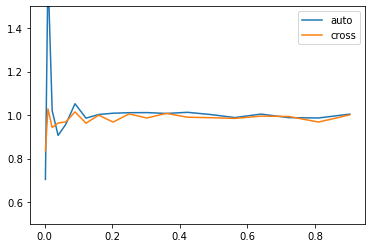

In [50]:
figure()
plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [51]:
gain_auto_mean = (gain_auto/1e5/(gains*gains)).mean(axis=0)[:n_gains]
gain_auto_std = (gain_auto/1e5/(gains*gains)).std(axis=0)[:n_gains]
gain_cross_mean = ((gain_cross_no_quant/1e5/(gains))**2).mean(axis=0)[:n_gains]
gain_cross_std = ((gain_cross_no_quant/1e5/(gains))**2).std(axis=0)[:n_gains]

In [52]:
gain_cross_mean[4]

0.9806401987185835

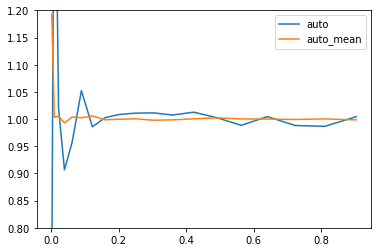

In [53]:
figure()
plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
plot(gains*gains, gain_auto_mean, label='auto_mean') 

#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

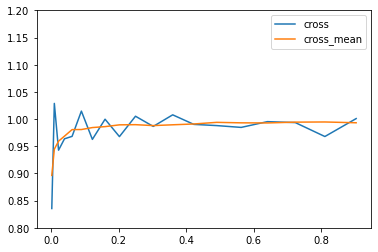

In [54]:
figure()
plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")
plot(gains*gains, gain_cross_mean, label='cross_mean')
#plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

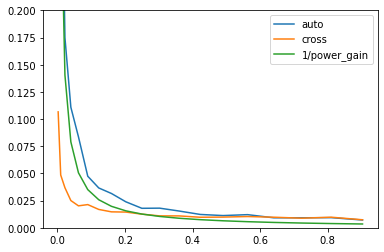

In [55]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

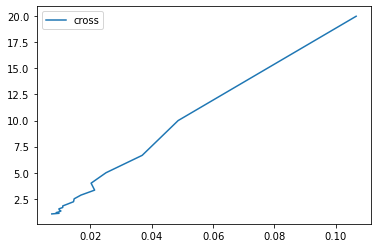

In [56]:
figure()
#plot(gains*gains, gain_auto_std, label="auto")
plot(gain_cross_std, 1/gains, label="cross")
#ylim(0,0.2)
legend()

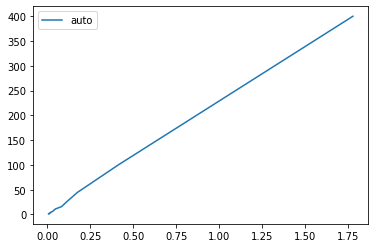

In [57]:
figure()
plot(gain_auto_std, 1/(gains*gains), label="auto")
#plot(gains, 1/gain_cross_std, label="cross")
#ylim(0,0.2)
legend()

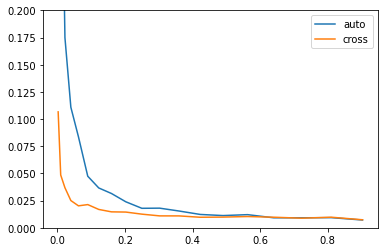

In [58]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

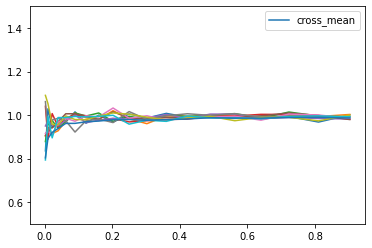

In [59]:
figure()
for i in range(10):
    plot(gains*gains, gain_cross_no_quant[i,:n_gains]*gain_cross_no_quant[i,:n_gains]/1e10/(gains*gains))
plot(gains*gains, gain_cross_mean*gain_cross_mean, label='cross_mean')
#plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [60]:
gains = np.arange(0.05,1,0.05)
n_gains = len(gains)
repeats = 100
stop_time = 50000
gain_cross_no_quant2 = np.zeros((repeats,n_gains))
gain_auto2 = np.zeros((repeats,n_gains))


for i,gain in enumerate(gains):
    for j in np.arange(repeats):
        signal = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        f_signal_on = gain*signal + noise_term  #this way to make quantization easier
        f_signal_off = noise_term_off
        #q_signal_on = quantizer(f_signal_on, nbits=8)
        #q_signal_off = quantizer(f_signal_off, nbits=8)
        #q_signal_on = f_signal_on
        #q_signal_off = f_signal_off
        auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
        auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
        #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
        #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
        gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
        #gain_cross.append(gain_cross1)
        gain_auto2[j,i] = gain_auto1
        gain_cross_no_quant2[j,i] = gain_cross_no_quant1
        print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.05, gain auto= 72.65225350579567, gain_cross_no_quant=2627.696922738163
gain 0.05, gain auto= -47.219656772125745, gain_cross_no_quant=2483.9713031468164
gain 0.05, gain auto= 1109.9039410083642, gain_cross_no_quant=2344.9473817936505
gain 0.05, gain auto= 346.47299074461625, gain_cross_no_quant=2380.326661155204
gain 0.05, gain auto= 469.9891238850396, gain_cross_no_quant=2175.1860467877345
gain 0.05, gain auto= 50.71857461064792, gain_cross_no_quant=2338.52161675343
gain 0.05, gain auto= 58.657554486679146, gain_cross_no_quant=2161.5146555936294
gain 0.05, gain auto= 320.2086100631277, gain_cross_no_quant=2119.956267150641
gain 0.05, gain auto= 407.9609210290655, gain_cross_no_quant=2386.5281263480706
gain 0.05, gain auto= -104.64853793885413, gain_cross_no_quant=2270.732198315949
gain 0.05, gain auto= -279.6024865113068, gain_cross_no_quant=2007.881625419894
gain 0.05, gain auto= 174.30787648082332, gain_cross_no_quant=2426.5305316086974
gain 0.05, gain auto= 14.5176230581855

gain 0.1, gain auto= 706.5695529667282, gain_cross_no_quant=4616.233941202933
gain 0.1, gain auto= 922.0115126764285, gain_cross_no_quant=4910.552843552704
gain 0.1, gain auto= 170.1835032762101, gain_cross_no_quant=4457.743969549219
gain 0.1, gain auto= 121.79937085306301, gain_cross_no_quant=4762.117241576396
gain 0.1, gain auto= -71.28627350868192, gain_cross_no_quant=4801.9463205624925
gain 0.1, gain auto= 479.02089794454514, gain_cross_no_quant=4442.541908255285
gain 0.1, gain auto= 239.2461972385281, gain_cross_no_quant=4583.099897794646
gain 0.1, gain auto= 734.0656627186036, gain_cross_no_quant=4915.2768757784415
gain 0.1, gain auto= 719.2393103152572, gain_cross_no_quant=4973.62539607588
gain 0.1, gain auto= 723.5110023332309, gain_cross_no_quant=4704.4540877003765
gain 0.1, gain auto= 665.7770672656552, gain_cross_no_quant=4946.735790538969
gain 0.1, gain auto= 895.0545353859707, gain_cross_no_quant=4904.651813565483
gain 0.1, gain auto= 809.5869455561551, gain_cross_no_quant

gain 0.15000000000000002, gain auto= 1233.3171407363625, gain_cross_no_quant=7307.706167933519
gain 0.15000000000000002, gain auto= 1240.9265616619668, gain_cross_no_quant=7603.055310461988
gain 0.15000000000000002, gain auto= 850.7293024457031, gain_cross_no_quant=7146.455989704435
gain 0.15000000000000002, gain auto= 947.3493923661663, gain_cross_no_quant=7413.955733192913
gain 0.15000000000000002, gain auto= 1469.9064186552278, gain_cross_no_quant=7342.366626194794
gain 0.15000000000000002, gain auto= 733.559657748141, gain_cross_no_quant=7412.767631762649
gain 0.15000000000000002, gain auto= 1276.9329850043869, gain_cross_no_quant=7735.523732814069
gain 0.15000000000000002, gain auto= 1085.272968858415, gain_cross_no_quant=7470.008348999975
gain 0.15000000000000002, gain auto= 1021.9421657091152, gain_cross_no_quant=7405.411913969714
gain 0.15000000000000002, gain auto= 1062.8688018999092, gain_cross_no_quant=7193.783618980806
gain 0.15000000000000002, gain auto= 1109.089571252589,

gain 0.15000000000000002, gain auto= 1500.6529790539935, gain_cross_no_quant=7633.715148850141
gain 0.15000000000000002, gain auto= 977.3352695659269, gain_cross_no_quant=7167.810071880093
gain 0.15000000000000002, gain auto= 906.0699854488848, gain_cross_no_quant=7443.950489029347
gain 0.15000000000000002, gain auto= 1151.3618429935814, gain_cross_no_quant=7562.771472885507
gain 0.2, gain auto= 3052.6837763596486, gain_cross_no_quant=10185.477999136649
gain 0.2, gain auto= 1936.8484101307477, gain_cross_no_quant=9988.593147291385
gain 0.2, gain auto= 2052.6623819706147, gain_cross_no_quant=9709.356067099088
gain 0.2, gain auto= 1997.3505947809826, gain_cross_no_quant=9943.724860668426
gain 0.2, gain auto= 1650.9605794439194, gain_cross_no_quant=10133.388961952995
gain 0.2, gain auto= 2185.021280101908, gain_cross_no_quant=9793.459810289614
gain 0.2, gain auto= 2342.042142279948, gain_cross_no_quant=9596.45349806169
gain 0.2, gain auto= 2346.2393383941308, gain_cross_no_quant=9872.9337

gain 0.25, gain auto= 2854.688275194072, gain_cross_no_quant=12017.570397140329
gain 0.25, gain auto= 2399.7850145571792, gain_cross_no_quant=12214.468830332742
gain 0.25, gain auto= 3503.482664054267, gain_cross_no_quant=12518.252543270542
gain 0.25, gain auto= 2719.085107213097, gain_cross_no_quant=12278.45926579493
gain 0.25, gain auto= 2425.578441381236, gain_cross_no_quant=12214.985160590693
gain 0.25, gain auto= 2831.786061859173, gain_cross_no_quant=12107.52795569913
gain 0.25, gain auto= 3031.5877956513214, gain_cross_no_quant=12359.703920916569
gain 0.25, gain auto= 3106.866680261912, gain_cross_no_quant=12194.847218650064
gain 0.25, gain auto= 3395.307095645039, gain_cross_no_quant=11947.486663929281
gain 0.25, gain auto= 3651.2097792864442, gain_cross_no_quant=12212.05362153775
gain 0.25, gain auto= 3147.78605156095, gain_cross_no_quant=12552.670958794286
gain 0.25, gain auto= 3140.1347330524077, gain_cross_no_quant=12190.762032420396
gain 0.25, gain auto= 3154.132586785927,

gain 0.3, gain auto= 3954.299598775491, gain_cross_no_quant=14601.982837726198
gain 0.3, gain auto= 4177.342801975821, gain_cross_no_quant=14692.083556600139
gain 0.3, gain auto= 4648.245390324591, gain_cross_no_quant=14546.40591017306
gain 0.3, gain auto= 4853.283475610027, gain_cross_no_quant=15101.585570753956
gain 0.3, gain auto= 4087.531521617355, gain_cross_no_quant=14702.91673497921
gain 0.3, gain auto= 4170.432500240742, gain_cross_no_quant=14894.2323549338
gain 0.3, gain auto= 4370.928663184735, gain_cross_no_quant=14729.025260207529
gain 0.3, gain auto= 4571.664392650149, gain_cross_no_quant=15013.745319770203
gain 0.3, gain auto= 4863.647475807826, gain_cross_no_quant=14705.325725999894
gain 0.3, gain auto= 4119.967700893503, gain_cross_no_quant=15147.800485281994
gain 0.3, gain auto= 4401.482545040533, gain_cross_no_quant=14797.96220867238
gain 0.3, gain auto= 4943.618677109764, gain_cross_no_quant=14748.305772210786
gain 0.3, gain auto= 3999.323028607214, gain_cross_no_qua

gain 0.35000000000000003, gain auto= 5600.615973381777, gain_cross_no_quant=17062.714910847677
gain 0.35000000000000003, gain auto= 5267.64367833225, gain_cross_no_quant=16856.16620551419
gain 0.35000000000000003, gain auto= 5922.770084877964, gain_cross_no_quant=17439.32310068711
gain 0.35000000000000003, gain auto= 6255.117956925984, gain_cross_no_quant=17449.799495478605
gain 0.35000000000000003, gain auto= 5997.1848055681985, gain_cross_no_quant=17382.68855856459
gain 0.35000000000000003, gain auto= 6594.6667496115115, gain_cross_no_quant=17281.833811277218
gain 0.35000000000000003, gain auto= 6448.215506993205, gain_cross_no_quant=17372.76405184546
gain 0.35000000000000003, gain auto= 5405.24463800661, gain_cross_no_quant=16914.995168610414
gain 0.35000000000000003, gain auto= 5746.638057842698, gain_cross_no_quant=16963.0135354046
gain 0.35000000000000003, gain auto= 6319.986816502038, gain_cross_no_quant=17226.686730978792
gain 0.35000000000000003, gain auto= 6118.823815807424, 

gain 0.4, gain auto= 8226.855314939829, gain_cross_no_quant=19923.425427598268
gain 0.4, gain auto= 7837.599577782115, gain_cross_no_quant=19824.64137603431
gain 0.4, gain auto= 7650.795770280798, gain_cross_no_quant=19634.39766685415
gain 0.4, gain auto= 7539.070968086446, gain_cross_no_quant=19829.068928560228
gain 0.4, gain auto= 7919.9629275023035, gain_cross_no_quant=19833.744803601334
gain 0.4, gain auto= 8097.763318727455, gain_cross_no_quant=19764.856882278953
gain 0.4, gain auto= 8169.8715490944305, gain_cross_no_quant=19931.92455358712
gain 0.4, gain auto= 7677.762366121264, gain_cross_no_quant=19824.503596130242
gain 0.4, gain auto= 8334.408971430246, gain_cross_no_quant=19931.761750950238
gain 0.4, gain auto= 8062.436950660624, gain_cross_no_quant=19609.34344198869
gain 0.4, gain auto= 7587.99102803869, gain_cross_no_quant=19701.18854521506
gain 0.4, gain auto= 7761.013827698822, gain_cross_no_quant=19695.045726106273
gain 0.4, gain auto= 8132.001844079161, gain_cross_no_qu

gain 0.45, gain auto= 10169.545981963878, gain_cross_no_quant=22333.19936414654
gain 0.45, gain auto= 10172.374290182153, gain_cross_no_quant=22074.082578179463
gain 0.45, gain auto= 9949.162799766651, gain_cross_no_quant=22135.845727193337
gain 0.45, gain auto= 9965.410664222763, gain_cross_no_quant=22122.313983695643
gain 0.45, gain auto= 9558.607406360243, gain_cross_no_quant=22431.38115897177
gain 0.45, gain auto= 10316.379430261113, gain_cross_no_quant=22349.603722825108
gain 0.45, gain auto= 10512.436101776424, gain_cross_no_quant=22350.4726055264
gain 0.45, gain auto= 9529.875279321779, gain_cross_no_quant=21983.492682017666
gain 0.45, gain auto= 10365.726469967005, gain_cross_no_quant=22479.986346189464
gain 0.45, gain auto= 10031.88181290614, gain_cross_no_quant=21988.172200520716
gain 0.45, gain auto= 10631.669721245482, gain_cross_no_quant=22490.533859639298
gain 0.45, gain auto= 10229.276798890605, gain_cross_no_quant=22194.692162674586
gain 0.45, gain auto= 10120.047661484

gain 0.5, gain auto= 12130.069937521163, gain_cross_no_quant=24155.44926006568
gain 0.5, gain auto= 13307.710845778282, gain_cross_no_quant=25194.069093975937
gain 0.5, gain auto= 12997.56456281725, gain_cross_no_quant=25274.624110463643
gain 0.5, gain auto= 12472.589616985104, gain_cross_no_quant=24728.391858686857
gain 0.5, gain auto= 12427.03635237513, gain_cross_no_quant=24756.60293680413
gain 0.5, gain auto= 12012.10705003282, gain_cross_no_quant=24836.820765758723
gain 0.5, gain auto= 12782.66305518736, gain_cross_no_quant=24725.300870583247
gain 0.5, gain auto= 12720.876910910862, gain_cross_no_quant=24842.67386100891
gain 0.5, gain auto= 12296.239496503025, gain_cross_no_quant=24651.4922225804
gain 0.5, gain auto= 12349.623002148313, gain_cross_no_quant=24862.56101159023
gain 0.5, gain auto= 12854.420158959547, gain_cross_no_quant=24861.552418006195
gain 0.5, gain auto= 12320.709126243892, gain_cross_no_quant=24952.41427311933
gain 0.5, gain auto= 12631.362164154132, gain_cross

gain 0.55, gain auto= 15184.599618758046, gain_cross_no_quant=27161.528320849528
gain 0.55, gain auto= 14715.828136625525, gain_cross_no_quant=27362.6843231273
gain 0.55, gain auto= 14744.993452368384, gain_cross_no_quant=27252.900645481473
gain 0.55, gain auto= 14923.205903358757, gain_cross_no_quant=27117.86099576895
gain 0.55, gain auto= 15056.302100477085, gain_cross_no_quant=27156.44569413764
gain 0.55, gain auto= 14419.46712501652, gain_cross_no_quant=27084.794465413324
gain 0.55, gain auto= 15271.13875523705, gain_cross_no_quant=27700.768958665005
gain 0.55, gain auto= 15552.973527393646, gain_cross_no_quant=27606.074974912095
gain 0.55, gain auto= 14950.36724736185, gain_cross_no_quant=27094.79186411292
gain 0.55, gain auto= 15336.442729652692, gain_cross_no_quant=27544.90325700615
gain 0.55, gain auto= 15033.571042149335, gain_cross_no_quant=27471.34057784086
gain 0.55, gain auto= 14339.676910603506, gain_cross_no_quant=27492.129128593613
gain 0.55, gain auto= 14834.4246628082

gain 0.6000000000000001, gain auto= 18494.97259112061, gain_cross_no_quant=30045.409502676786
gain 0.6000000000000001, gain auto= 17524.21946288069, gain_cross_no_quant=29717.24067366005
gain 0.6000000000000001, gain auto= 18796.110441185672, gain_cross_no_quant=29941.895062285992
gain 0.6000000000000001, gain auto= 18034.60709087007, gain_cross_no_quant=30027.279518979896
gain 0.6000000000000001, gain auto= 17886.18012682484, gain_cross_no_quant=29609.75280369134
gain 0.6000000000000001, gain auto= 18123.729555866594, gain_cross_no_quant=29888.352148325877
gain 0.6000000000000001, gain auto= 18548.482348232894, gain_cross_no_quant=30041.528789499596
gain 0.6000000000000001, gain auto= 17518.32538899818, gain_cross_no_quant=29667.90338929795
gain 0.6000000000000001, gain auto= 18531.964995433707, gain_cross_no_quant=29720.45894188158
gain 0.6000000000000001, gain auto= 17833.54854058208, gain_cross_no_quant=29839.283188985843
gain 0.6000000000000001, gain auto= 18311.765996293485, gain

gain 0.6500000000000001, gain auto= 20902.929046373116, gain_cross_no_quant=32427.62673187669
gain 0.6500000000000001, gain auto= 21343.716290621094, gain_cross_no_quant=32146.329042816757
gain 0.6500000000000001, gain auto= 20856.668840518527, gain_cross_no_quant=32070.34433191373
gain 0.6500000000000001, gain auto= 21250.460368165324, gain_cross_no_quant=32267.29671791569
gain 0.6500000000000001, gain auto= 21296.56945747786, gain_cross_no_quant=32344.536418732874
gain 0.6500000000000001, gain auto= 21248.629327955627, gain_cross_no_quant=32454.15295606335
gain 0.6500000000000001, gain auto= 21053.907125734557, gain_cross_no_quant=32313.043160849997
gain 0.6500000000000001, gain auto= 20462.931232429793, gain_cross_no_quant=32260.401508158346
gain 0.6500000000000001, gain auto= 21838.398603628943, gain_cross_no_quant=32655.27779878117
gain 0.6500000000000001, gain auto= 21402.982188620917, gain_cross_no_quant=32324.197492015195
gain 0.6500000000000001, gain auto= 20399.952085125333, 

gain 0.7000000000000001, gain auto= 24576.717374387925, gain_cross_no_quant=34472.684832957726
gain 0.7000000000000001, gain auto= 24129.012502800193, gain_cross_no_quant=34730.198359160546
gain 0.7000000000000001, gain auto= 24674.089238620167, gain_cross_no_quant=34853.07152156658
gain 0.7000000000000001, gain auto= 24043.534032656746, gain_cross_no_quant=34379.877261947164
gain 0.7000000000000001, gain auto= 24652.31039663057, gain_cross_no_quant=34940.21433432233
gain 0.7000000000000001, gain auto= 24244.970796918707, gain_cross_no_quant=34799.30730871723
gain 0.7000000000000001, gain auto= 24073.147010427077, gain_cross_no_quant=34077.45746402725
gain 0.7000000000000001, gain auto= 24480.709955385864, gain_cross_no_quant=34576.331820514584
gain 0.7000000000000001, gain auto= 24862.535970299912, gain_cross_no_quant=34973.62299771513
gain 0.7000000000000001, gain auto= 25216.87311989397, gain_cross_no_quant=35191.71635431848
gain 0.7000000000000001, gain auto= 23871.869653039663, ga

gain 0.7000000000000001, gain auto= 24724.765516773623, gain_cross_no_quant=34967.230212374474
gain 0.7000000000000001, gain auto= 24757.835543045847, gain_cross_no_quant=34850.274480241846
gain 0.7000000000000001, gain auto= 23902.66493827309, gain_cross_no_quant=34848.144750702464
gain 0.7000000000000001, gain auto= 24025.55688504284, gain_cross_no_quant=34319.04707436453
gain 0.7000000000000001, gain auto= 25439.33236437683, gain_cross_no_quant=35158.56934068248
gain 0.7000000000000001, gain auto= 23815.001905173936, gain_cross_no_quant=34356.21136499569
gain 0.7000000000000001, gain auto= 24217.10327557542, gain_cross_no_quant=34448.939232792545
gain 0.7000000000000001, gain auto= 24307.912902676675, gain_cross_no_quant=34593.79711477219
gain 0.7000000000000001, gain auto= 24676.613480300926, gain_cross_no_quant=34797.27135646101
gain 0.7000000000000001, gain auto= 23931.799311956616, gain_cross_no_quant=34567.01931303322
gain 0.7500000000000001, gain auto= 28657.489435906507, gain

gain 0.7500000000000001, gain auto= 28672.59511467348, gain_cross_no_quant=37620.80022385838
gain 0.7500000000000001, gain auto= 28073.800095952232, gain_cross_no_quant=37017.90382200005
gain 0.7500000000000001, gain auto= 28300.40277967428, gain_cross_no_quant=37164.10650539655
gain 0.7500000000000001, gain auto= 28083.208412824977, gain_cross_no_quant=37563.44892140468
gain 0.7500000000000001, gain auto= 28408.77862153149, gain_cross_no_quant=37248.86428345598
gain 0.7500000000000001, gain auto= 27874.989791781816, gain_cross_no_quant=37276.740656744645
gain 0.7500000000000001, gain auto= 27865.75905038591, gain_cross_no_quant=36980.060532844764
gain 0.7500000000000001, gain auto= 28420.084046957192, gain_cross_no_quant=37551.34916430352
gain 0.7500000000000001, gain auto= 28223.623968318083, gain_cross_no_quant=37305.653433004096
gain 0.7500000000000001, gain auto= 28473.046865133314, gain_cross_no_quant=37588.994813946185
gain 0.7500000000000001, gain auto= 28197.78848291256, gain_

gain 0.8, gain auto= 31914.27357633796, gain_cross_no_quant=39702.69045972078
gain 0.8, gain auto= 31864.643550404828, gain_cross_no_quant=39974.15766144205
gain 0.8, gain auto= 31667.135267276375, gain_cross_no_quant=39680.47546400238
gain 0.8, gain auto= 31491.305325478213, gain_cross_no_quant=39765.14638913113
gain 0.8, gain auto= 31682.67033284287, gain_cross_no_quant=39676.239456809424
gain 0.8, gain auto= 32254.822317989485, gain_cross_no_quant=40050.473673846755
gain 0.8, gain auto= 31385.386981123098, gain_cross_no_quant=39650.62001366135
gain 0.8, gain auto= 32649.63715834992, gain_cross_no_quant=40094.832402417065
gain 0.8, gain auto= 31805.272246974906, gain_cross_no_quant=39823.204935591246
gain 0.8, gain auto= 31943.95664901784, gain_cross_no_quant=39539.78346090641
gain 0.8, gain auto= 32189.993628180426, gain_cross_no_quant=39980.0150099009
gain 0.8500000000000001, gain auto= 35478.15370038521, gain_cross_no_quant=42138.879324882335
gain 0.8500000000000001, gain auto= 36

gain 0.8500000000000001, gain auto= 36164.7305531429, gain_cross_no_quant=42677.08700371753
gain 0.8500000000000001, gain auto= 36369.580914733124, gain_cross_no_quant=42307.33545469289
gain 0.8500000000000001, gain auto= 35963.57718520208, gain_cross_no_quant=41968.27386042462
gain 0.8500000000000001, gain auto= 36261.11684027481, gain_cross_no_quant=42261.56406856664
gain 0.8500000000000001, gain auto= 36138.18331699522, gain_cross_no_quant=42341.13496913093
gain 0.8500000000000001, gain auto= 35871.51248320078, gain_cross_no_quant=42015.42427182876
gain 0.8500000000000001, gain auto= 35203.142772910665, gain_cross_no_quant=42083.669010015605
gain 0.8500000000000001, gain auto= 36217.388399757474, gain_cross_no_quant=42461.75944177949
gain 0.8500000000000001, gain auto= 36418.95810644171, gain_cross_no_quant=42401.20425923085
gain 0.8500000000000001, gain auto= 35599.78084285551, gain_cross_no_quant=42235.3589017815
gain 0.8500000000000001, gain auto= 36843.53849128549, gain_cross_no

gain 0.9000000000000001, gain auto= 41008.4667262185, gain_cross_no_quant=44699.78694619193
gain 0.9000000000000001, gain auto= 41181.11774177468, gain_cross_no_quant=45014.64256559934
gain 0.9000000000000001, gain auto= 40724.75376790565, gain_cross_no_quant=45288.63338741471
gain 0.9000000000000001, gain auto= 40985.349961095744, gain_cross_no_quant=45042.920303725
gain 0.9000000000000001, gain auto= 41227.642634968506, gain_cross_no_quant=45094.251002886704
gain 0.9000000000000001, gain auto= 40080.95374752379, gain_cross_no_quant=44652.222274202126
gain 0.9000000000000001, gain auto= 40291.64347467178, gain_cross_no_quant=45054.69000495683
gain 0.9000000000000001, gain auto= 41609.64283075126, gain_cross_no_quant=45332.96761358265
gain 0.9000000000000001, gain auto= 40871.80988498854, gain_cross_no_quant=44975.57165636168
gain 0.9000000000000001, gain auto= 40077.30355345308, gain_cross_no_quant=45259.29636957032
gain 0.9000000000000001, gain auto= 41046.17165366178, gain_cross_no_

gain 0.9500000000000001, gain auto= 45745.492622515914, gain_cross_no_quant=47397.87717858946
gain 0.9500000000000001, gain auto= 45015.938721479964, gain_cross_no_quant=47459.759817852566
gain 0.9500000000000001, gain auto= 45093.170855956945, gain_cross_no_quant=47306.524523284155
gain 0.9500000000000001, gain auto= 45239.036310461524, gain_cross_no_quant=47130.593559921996
gain 0.9500000000000001, gain auto= 46182.93108843903, gain_cross_no_quant=47770.51598904327
gain 0.9500000000000001, gain auto= 45606.00281227626, gain_cross_no_quant=47678.02556995237
gain 0.9500000000000001, gain auto= 44901.34051999935, gain_cross_no_quant=47035.731865231006
gain 0.9500000000000001, gain auto= 44509.0851342467, gain_cross_no_quant=47302.65102415909
gain 0.9500000000000001, gain auto= 45721.349977238366, gain_cross_no_quant=47319.31935753858
gain 0.9500000000000001, gain auto= 44785.519713631635, gain_cross_no_quant=47308.88670218877
gain 0.9500000000000001, gain auto= 45508.25704315046, gain_c

In [61]:
gain_auto_mean2 = (gain_auto2/stop_time/(gains*gains)).mean(axis=0)
gain_auto_std2 = (gain_auto2/stop_time/(gains*gains)).std(axis=0)
gain_cross_mean2 = ((gain_cross_no_quant2/stop_time/(gains))**2).mean(axis=0)
gain_cross_std2 = ((gain_cross_no_quant2/stop_time/(gains))**2).std(axis=0)

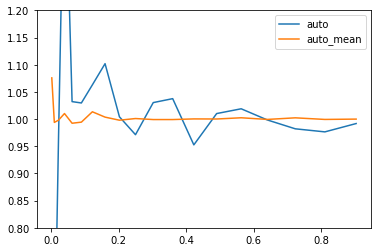

In [62]:
figure()
plot(gains*gains, gain_auto2[0,:n_gains]/stop_time/(gains*gains), label='auto') 
plot(gains*gains, gain_auto_mean2, label='auto_mean') 

#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

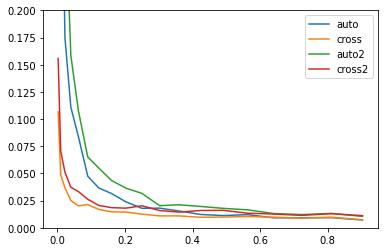

In [63]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
plot(gains*gains, gain_auto_std2, label="auto2")
plot(gains*gains, gain_cross_std2, label="cross2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

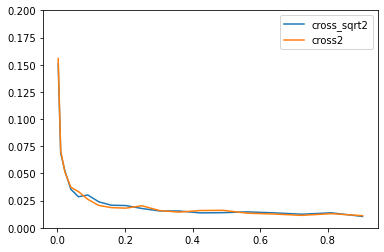

In [64]:
figure()

plot(gains*gains, gain_cross_std*np.sqrt(2), label="cross_sqrt2")
plot(gains*gains, gain_cross_std2, label="cross2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

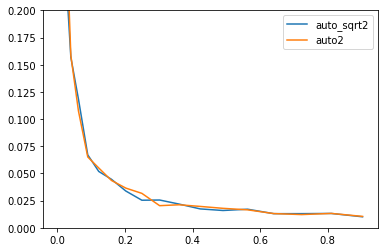

In [65]:
figure()

plot(gains*gains, gain_auto_std*np.sqrt(2), label="auto_sqrt2")
plot(gains*gains, gain_auto_std2, label="auto2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

In [66]:
sigma_levels_bits = np.arange(0.25,6,0.25)
sigma_levels = 2**sigma_levels_bits

In [67]:
variances_quantized = []
for sigma1 in sigma_levels:
    signal = np.random.normal(0, sigma1, 500000)
    variances_quantized.append(quantizer(signal,nbits=6).std())

In [68]:
variances_quantized = np.array(variances_quantized)

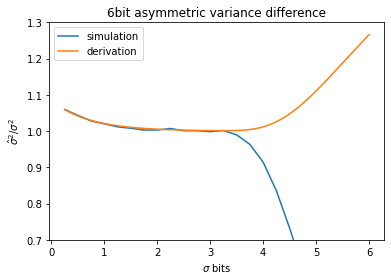

In [69]:
figure()
plot(sigma_levels_bits, variances_quantized**2/sigma_levels**2, label="simulation")
plot(np.log2(1.0/eps_arr),var_set, label= "derivation")
title("6bit asymmetric variance difference")
ylabel(r'$\hat{\sigma}^2$/$\sigma^2$')
xlabel(r"$\sigma$ bits")
ylim(0.7,1.3)
legend()